### Import libraries

In [1]:
import os
import sys
sys.path.append("..")
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# options: rbf, periodic
print('Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
d = True if kernel.split('_')[-1] == '2D' else False
save_dir = os.path.expanduser('~/Downloads/GPT_' + kernel)

Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D
rbf_const_2D
How many observations? (deafult 150000)
1
Do you want to overwrite data? True/False
False


In [3]:
data = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise = False, d = d, ordered = True)

['em_te_2.npy', 'pad_pos_tr.npy', 'pad_pos_te.npy', 'em_te.npy', 'em_tr.npy', 'pad_y_fren_tr.npy', 'pad_y_fren_te.npy', 'em_tr_2.npy']


In [4]:
a = data[-4][1, :10].reshape(1, -1)

In [5]:
b = data[1][1, :10].reshape(1, -1)

In [6]:
c = data[-3][1, :10].reshape(1, -1)

In [7]:
dd = data[-1][1, :10].reshape(1, -1)

In [8]:
a

array([[264., 244., 340., 289., 314., 265., 254., 249., 285., 242.]])

In [9]:
b

array([[ 7.30813801,  5.38459099, 14.91017682,  9.8774689 , 12.35579582,
         7.4977443 ,  6.36305617,  5.85732549,  9.41111518,  5.15314729]])

In [10]:
c

array([[ 1.42948886,  3.97891532,  3.30185699, -0.46714584, -2.88594971,
        -3.64957459,  3.47368   , -0.58534392, -1.17222729, -0.57185026]])

In [11]:
dd

array([[0., 0., 0., 1., 1., 1., 0., 1., 1., 1.]])

In [12]:
batch_creator.create_batch_2d(a, b, c, dd, batch_s=1, context_p=2)

([array([[-0.57185026,  3.97891532, -0.58534392,  3.47368   , -3.64957459,
          -1.17222729, -0.46714584, -2.88594971,  1.42948886,  3.30185699]]),
  array([[ 5.15314729,  5.38459099,  5.85732549,  6.36305617,  7.4977443 ,
           9.41111518,  9.8774689 , 12.35579582,  7.30813801, 14.91017682]]),
  array([[242., 244., 249., 254., 265., 285., 289., 314., 264., 340.]]),
  array([[1., 0., 1., 0., 1., 1., 1., 1., 0., 0.]])],
 [8])

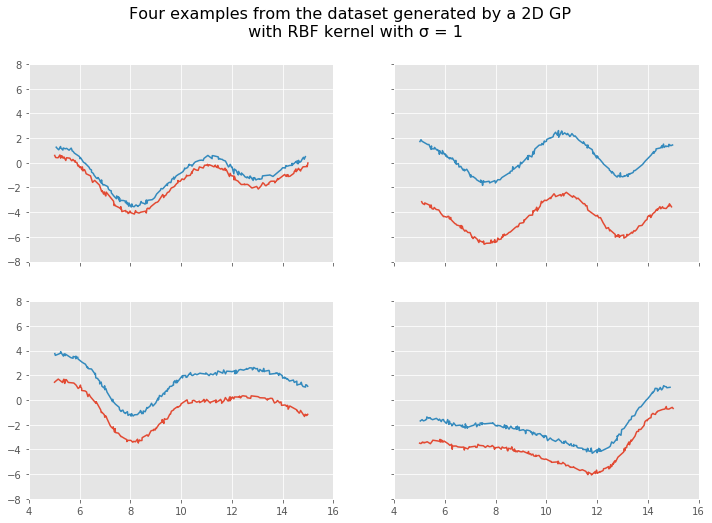

In [13]:
if d:
    plotter.plot_2d_examples(data[2], data[-2], data[0])
else:
    plotter.plot_examples(data[0], data[4])

In [14]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [15]:
# batch_x_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_x_tr, pad_y_fren_tr, batch_s=1)

Already exists
Restored from /Users/omernivron/Downloads/GPT_rbf_const_2D/ckpt/check_run_9999/ckpt-42


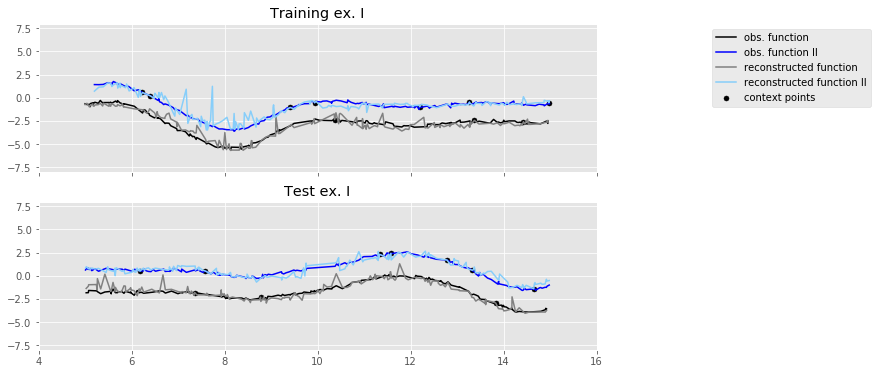

Epoch 0 batch 0 train Loss -0.0270 test Loss -0.0029 with training MSE metric 0.2001 and testing MSE metric 0.2515
learning rate is 0.0003000000142492354
r squared training, series 0: 0.8597970819721757, series 1: 0.8335250017816758
r squared testing, series 0: 0.8142811094748061, series 1: 0.7934584103793111


KeyboardInterrupt: 

In [16]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 9999; step = 0; train_steps = 35000; heads = 8; ℯ = 256; context = 10
    l1, _, l2, l3 = [256, 256, 64, 32]
    name_comp = 'run_' + str(run) 
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp
#     lr_fn = tf.optimizers.schedules.PolynomialDecay(9e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
#     ℯ, l1, _, l2, l3 = helpers.load_spec(folder, ℯ, l, context,  d = d)
    helpers.mkdir(folder)
    if d:
        decoder = experimental2d_model.Decoder(ℯ, l1, l2, l3, num_heads = heads)
    else:
        decoder = experimental_model.Decoder(ℯ, l1, l2, l3, num_heads = heads)
    tf.random.set_seed(443)  
    num_batches = int(data[5].shape[0] / batch_s) if d else int(data[4].shape[0] / batch_s)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
#     optimizer_c = tf.keras.optimizers.Adam(3e-4)
    with writer.as_default():
        for epoch in range(EPOCHS):
            
            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    b_data = batch_creator.create_batch(em_x = data[-4], x = data[1], y = data[-3],  em_2 = data[-1], batch_s=64, d=d)
#                     b_data, c = batch_creator.create_batch_2d(em_x = data[-4], x = data[1], y = data[-3],  em_2 = data[-1], batch_s=64)
# #                     print('c: ', c)
#                     if type(c) is list:
#                         cols = [np.arange(c[i], b_data[2].shape[1] -1, 1) for i in range(len(c))]
#                         cc = np.concatenate(cols, axis=0 )
#                         rows = [np.repeat(i, len(m)) for i, m in enumerate(cols)]
#                         r = np.concatenate(rows, axis=0)
#                         to_gather = np.concatenate((r.reshape(-1, 1), cc.reshape(-1,1)), 1)
#                     else:
#                         to_gather = None
#                     pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True, x2 = b_data[3], to_gather=to_gather, context_p = c)
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True, x2 = b_data[3], to_gather=None, context_p = context)
                else:
                    b_data = batch_creator.create_batch(em_x = data[3], x = data[0], y = data[4], batch_s=64, d=d)
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], context_p = context)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context)
                if batch_n % 300 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        b_data_te = batch_creator.create_batch(em_x = data[3], x = data[2], y = data[6],  em_2 = data[0], batch_s=64, d=d)


#                         b_data_te, c_te = batch_creator.create_batch_2d(em_x = data[3], x = data[2], y = data[6],  em_2 =  data[0], batch_s=64)
#                         if type(c_te) is list:
#                             cols = [np.arange(c_te[i], b_data_te[2].shape[1] -1, 1) for i in range(len(c_te))]
#                             cc = np.concatenate(cols, axis=0 )
#                             rows = [np.repeat(i, len(m)) for i, m in enumerate(cols)]
#                             r = np.concatenate(rows, axis=0)
#                             to_gather_te = np.concatenate((r.reshape(-1, 1), cc.reshape(-1,1)), 1)
#                         else:
#                             to_gather_te = None
                        
                        
#                         pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=to_gather_te, context_p = context, d=True)
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, b_data_te[2], b_data_te[0], d = True, x2_te = b_data_te[3], to_gather=None, context_p = context)


                        
#                         idd = np.random.choice(np.arange(0, 64))
#                         seq_l = to_gather[to_gather[:, 0] == idd][0, 1]
#                         plt.scatter(b_data[1][idd, :seq_l], b_data[0][idd, :seq_l] , c = 'blue')
#                         plt.scatter(b_data[1][idd, seq_l:], pred[idd][(seq_l - 1):])
# #                         plt.savefig('foo{}.png'.format((batch_n / num_batches) + (epoch + 1))
#                         plt.show()
                        
                        plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = b_data_te[1], y_te = b_data_te[0], em_2_te = b_data_te[3] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = data[2][:500, :], y_te = data[5][:500, :], context_p = context)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = data[1][:500, :], y_te = data[5][:500, :], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    if d:
                        m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
                        m0_te, m1_te = metrics.r_sq_2d(b_data_te[0][:, 1:], pred_te.numpy(), b_data_te[3][:, 1:], context_p = context)
                        print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
                        print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))

#                     else: 
#                         print('r squared training: ', metrics.r_squared(m_tr.result(), b_data[0][:, (context + 1):]))
#                         print('r squared testing: ', metrics.r_squared(m_te.result(), data[5][:500, (context + 1):], batch_s = 500))


                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [45]:
decoder.layers[8].get_weights()


[array([[ 0.0994584 , -0.07901419],
        [ 0.02931255,  0.07446103],
        [ 0.06934623,  0.09376211],
        [ 0.08912712,  0.07057637],
        [-0.02203402,  0.12040599],
        [ 0.10718183,  0.07272788],
        [-0.1475881 ,  0.00101031],
        [ 0.08825085, -0.01018424],
        [ 0.01356253, -0.05636702],
        [-0.0342591 , -0.11699593],
        [-0.03429391, -0.01082861],
        [ 0.1167584 , -0.12516107],
        [ 0.0836991 , -0.1034494 ],
        [ 0.1019862 , -0.12493331],
        [-0.12664492,  0.05668859],
        [-0.04214613, -0.07760796],
        [-0.00963144, -0.14213358],
        [-0.00019182, -0.07203407],
        [-0.09954665,  0.15671401],
        [ 0.08714074, -0.10836503],
        [ 0.03294058,  0.08867136],
        [ 0.1637403 , -0.13749526],
        [-0.12669462,  0.03311092],
        [ 0.08153209,  0.13841269],
        [ 0.00787622, -0.07914694],
        [ 0.00084846,  0.04610504],
        [ 0.05968849,  0.05627827],
        [-0.11087201,  0.017

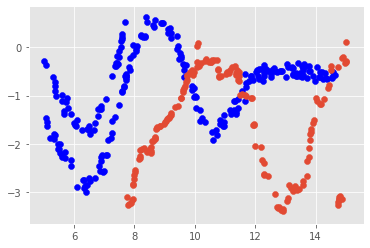

In [8]:
plt.scatter(b_data[1][idd, :seq_l], b_data[0][idd, :seq_l] , c = 'blue')
plt.scatter(b_data[1][idd, seq_l:], pred[idd][(seq_l - 1):])

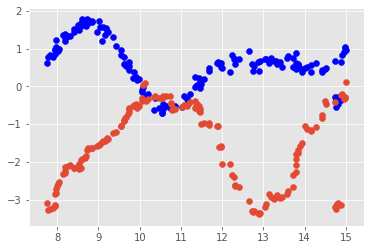

In [9]:
plt.scatter(b_data[1][idd, seq_l:], b_data[0][idd, seq_l:] , c = 'blue')
plt.scatter(b_data[1][idd, seq_l:], pred[idd][(seq_l - 1):])

In [17]:
from tensorboard.plugins import projector
# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
subwords = np.concatenate(([0, 1], np.unique(b_data[2])))
with open(os.path.join(logdir, 'metadata.tsv'), "w") as f:
    for subword in subwords:
        f.write("learnt {}\n".format(subword))
    for unknown in np.arange(0, 2000)[~np.isin(range(0, 2000), subwords)]:
        f.write("unknown #{}\n".format(unknown))
weights = tf.Variable(decoder.layers[0].get_weights()[0])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(logdir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(logdir, config)

In [18]:
from inference import infer

In [19]:
from helpers import masks

In [22]:
decoder.layers

sample # 0, r squared: 0.8188124358439175


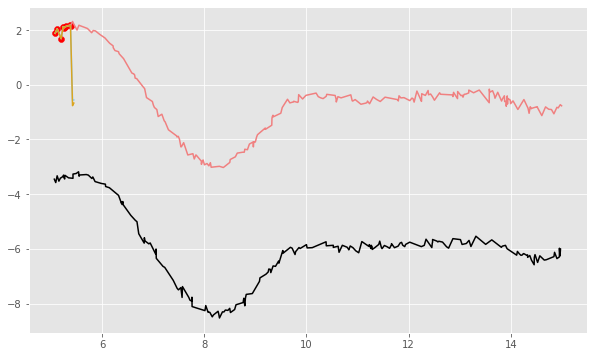

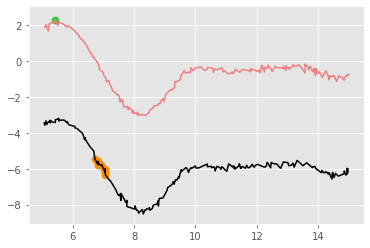

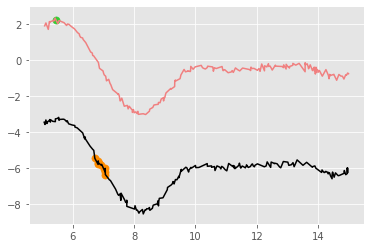

sample # 0, r squared: 0.9955621561647305


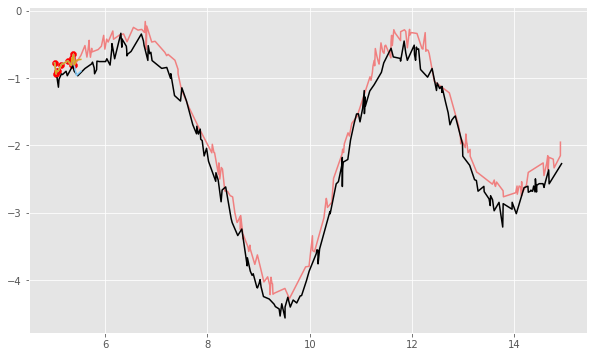

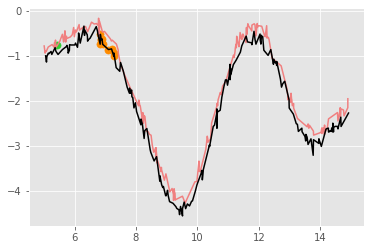

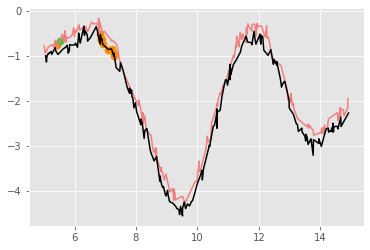

sample # 0, r squared: -5931.638936248571


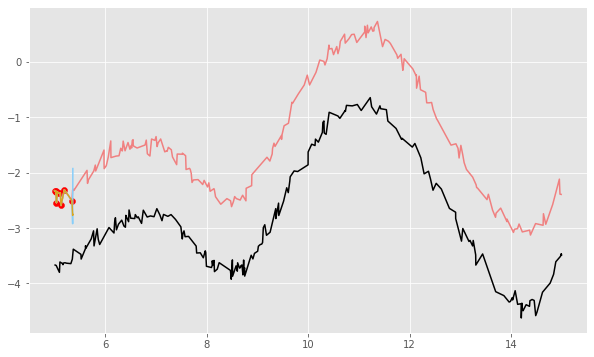

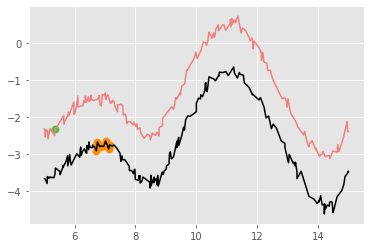

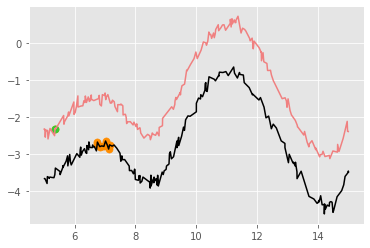

sample # 0, r squared: -322.66485221243505


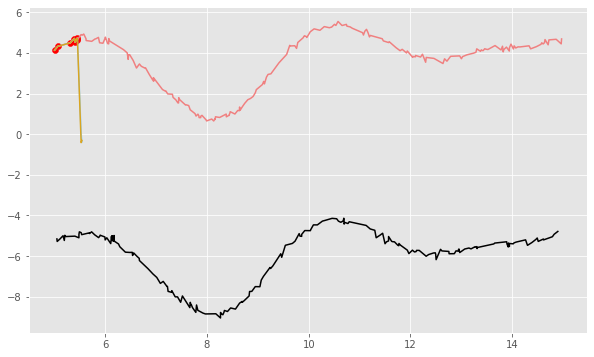

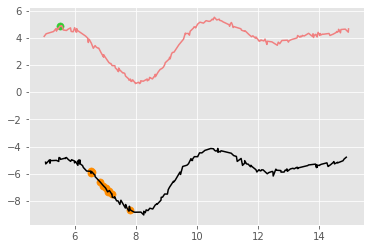

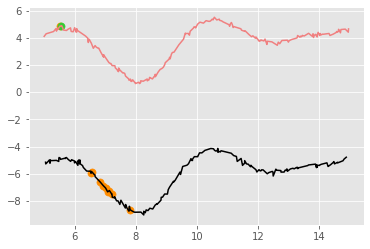

sample # 0, r squared: 0.9270530509503322


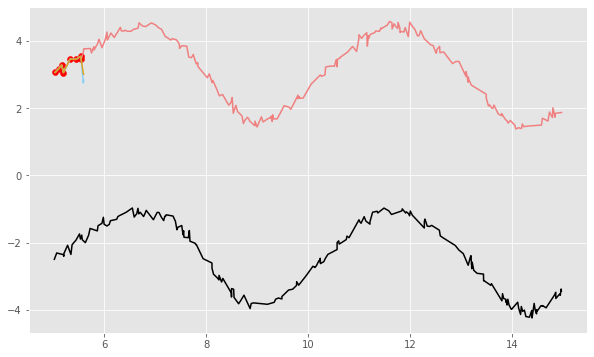

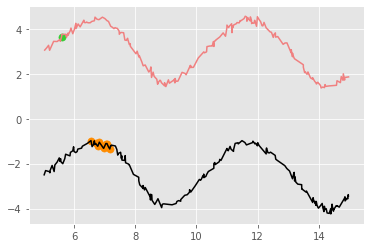

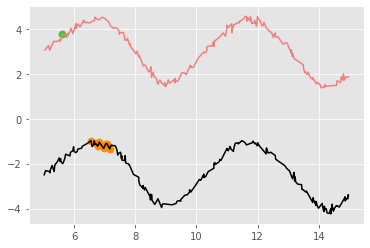

sample # 0, r squared: 0.8898614592646724


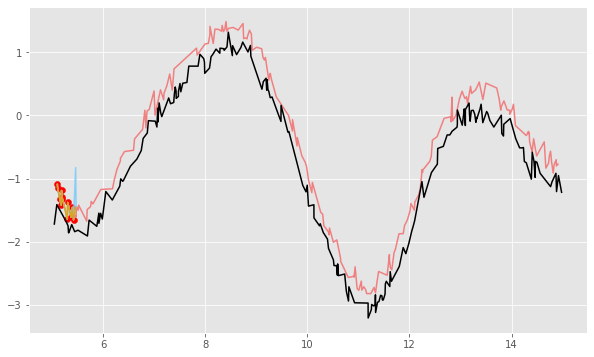

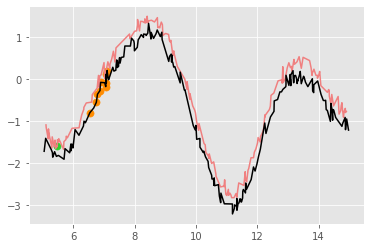

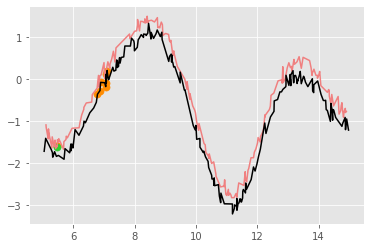

sample # 0, r squared: 0.9609762350127988


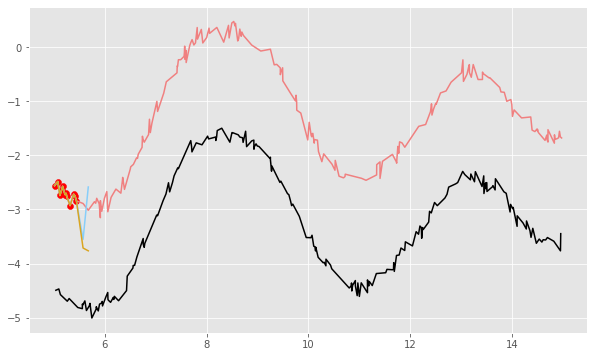

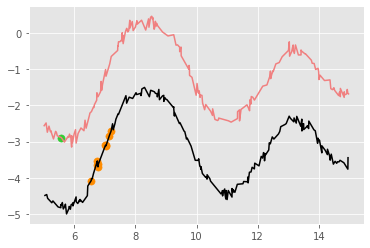

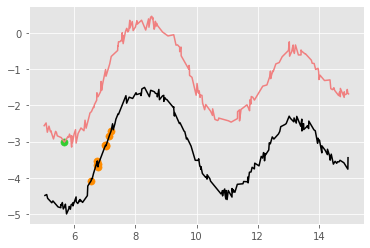

sample # 0, r squared: -1.1439839607987898


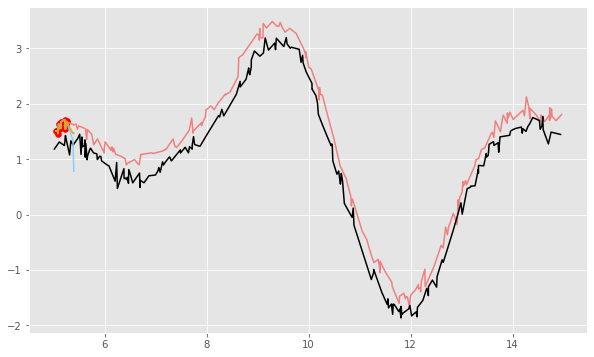

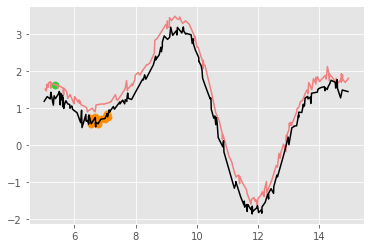

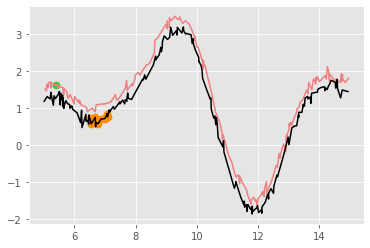

sample # 0, r squared: 0.9968855057812464


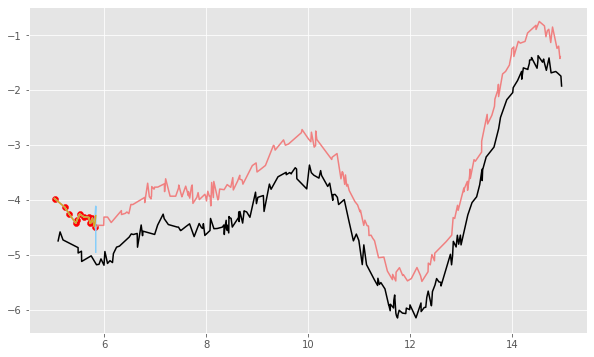

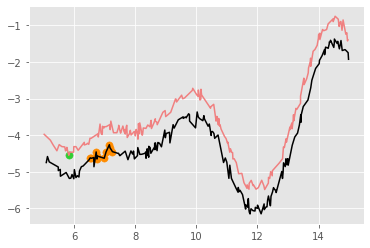

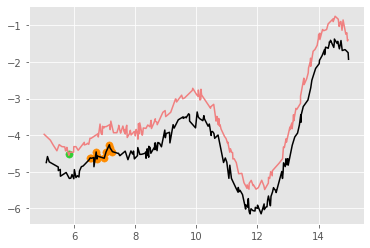

sample # 0, r squared: 0.9582931382296052


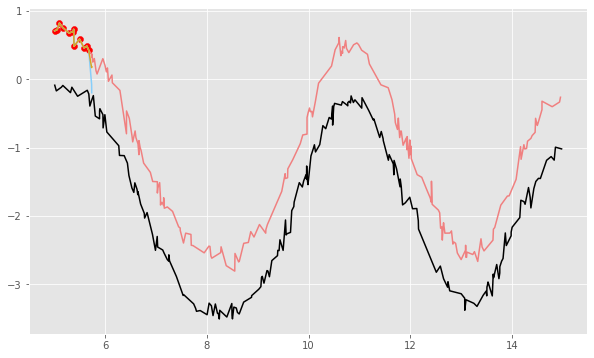

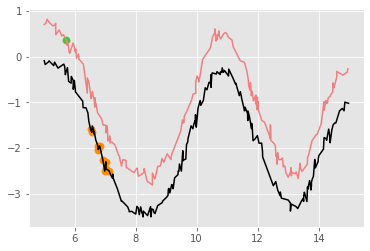

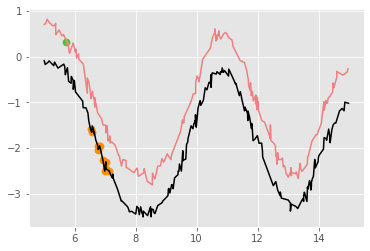

sample # 0, r squared: 0.8485770313219566


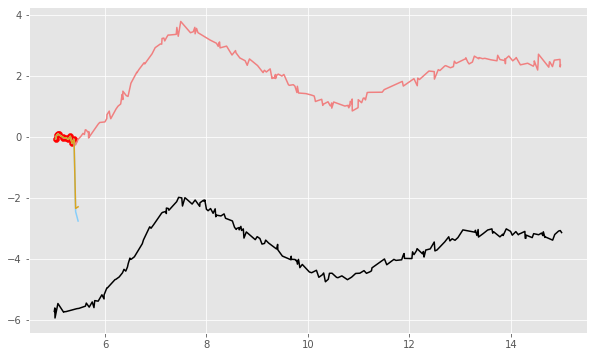

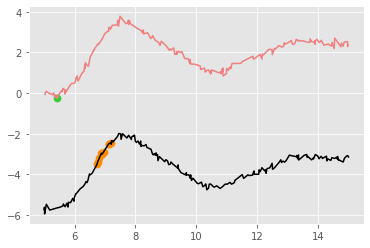

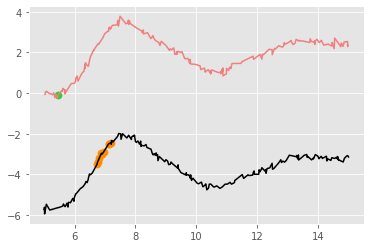

sample # 0, r squared: 0.9928380732738806


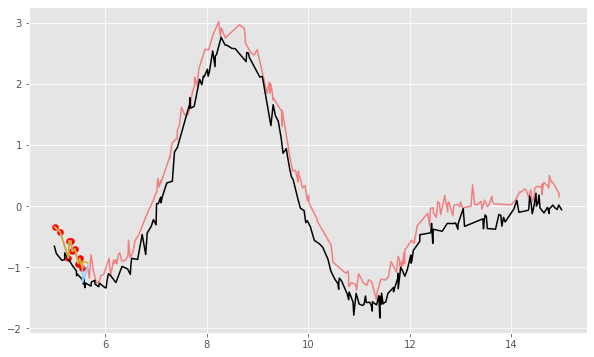

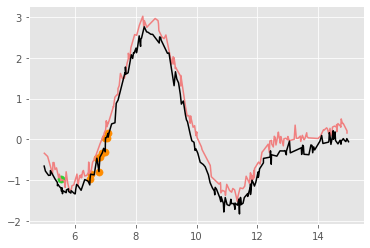

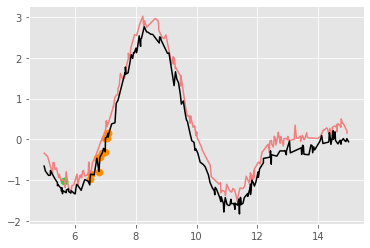

sample # 0, r squared: -274.4412146637066


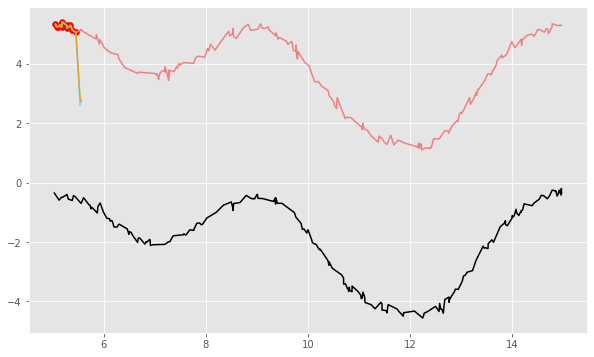

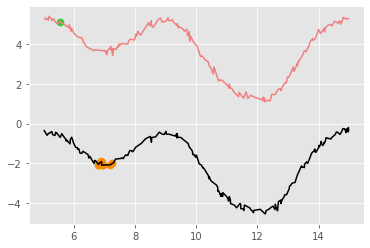

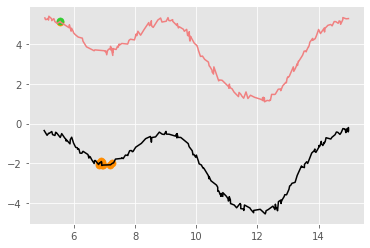

sample # 0, r squared: 0.9895088155582168


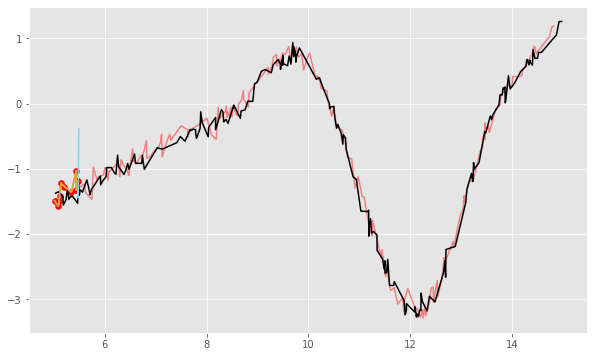

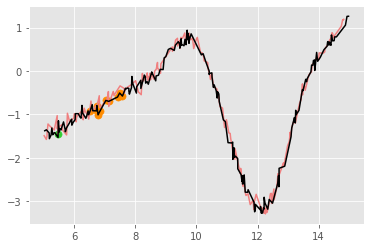

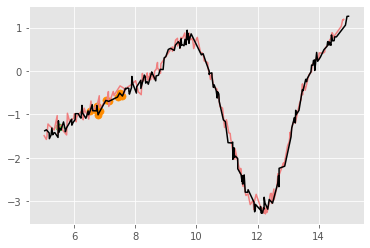

sample # 0, r squared: 0.992263808256373


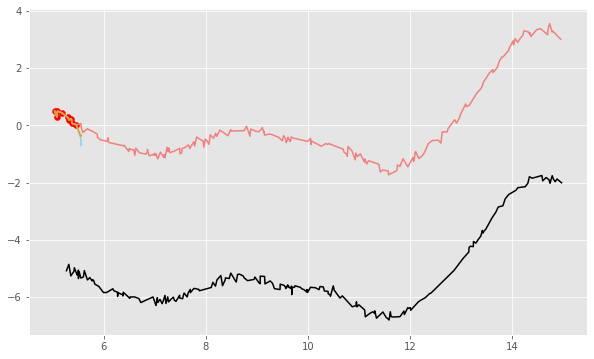

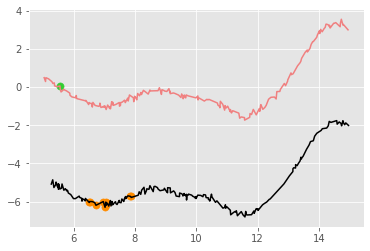

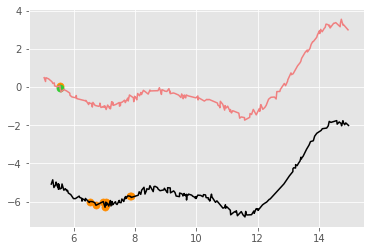

sample # 0, r squared: 0.8748068196012938


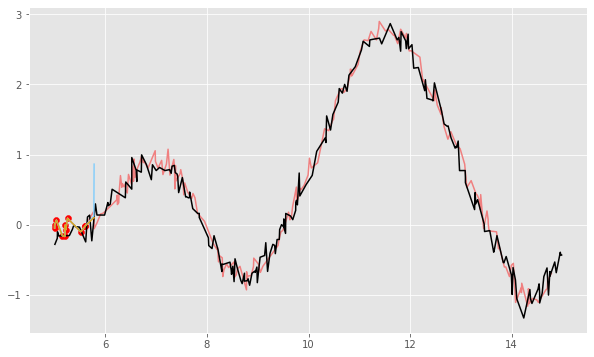

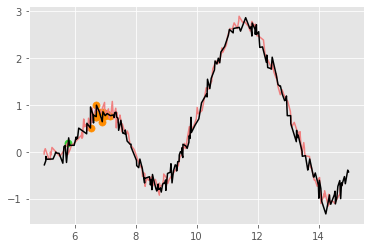

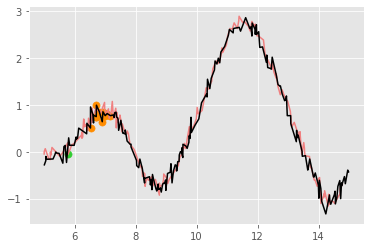

sample # 0, r squared: 0.9734932188225659


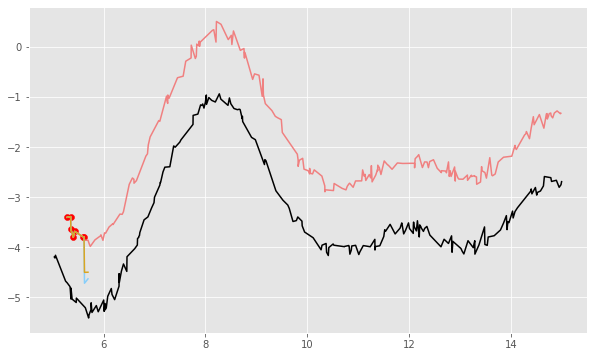

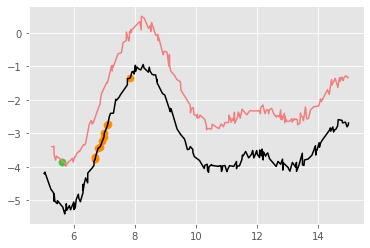

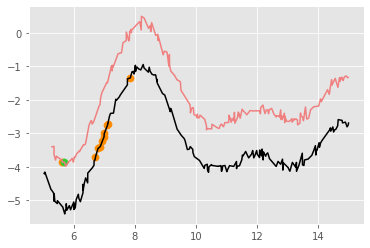

sample # 0, r squared: 0.5715331828181867


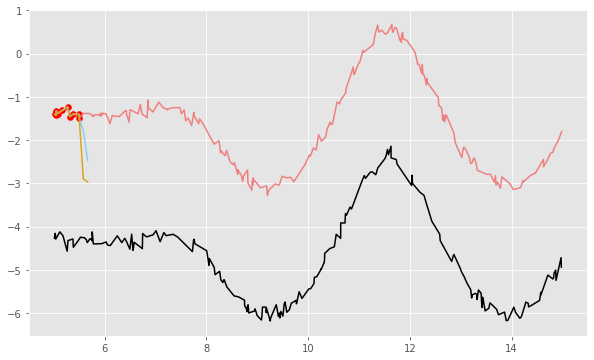

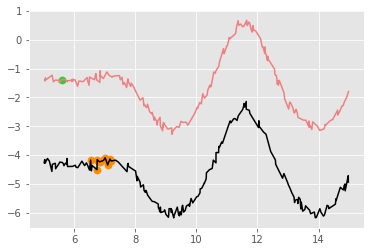

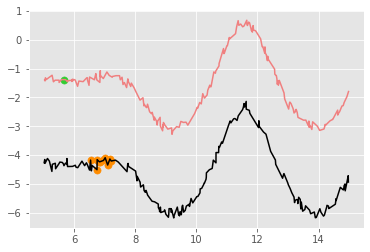

sample # 0, r squared: 0.9856506199879486


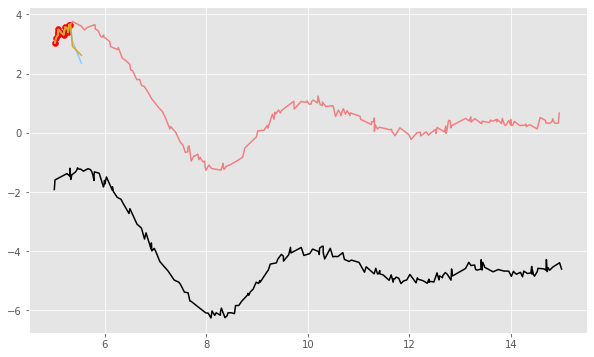

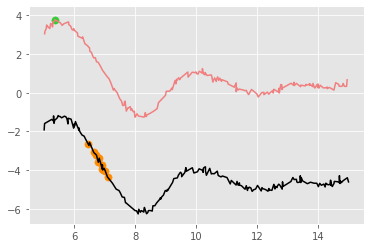

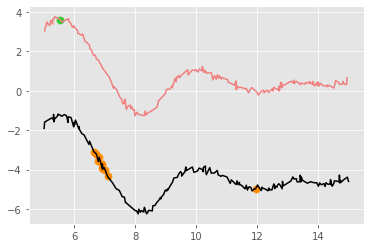

sample # 0, r squared: 0.9516298764547908


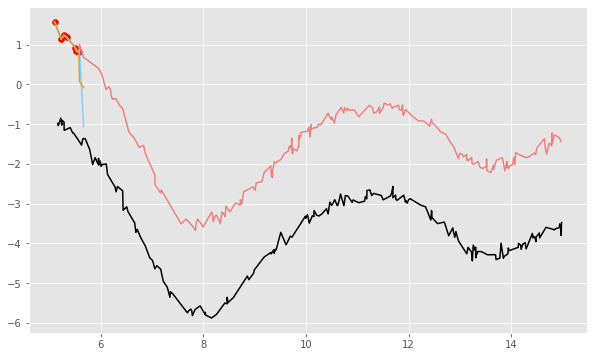

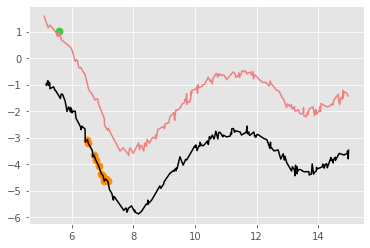

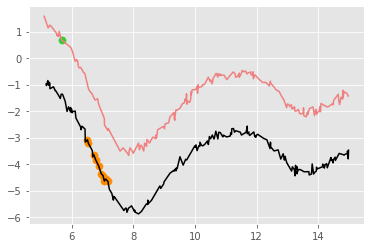

sample # 0, r squared: 0.7781769362681416


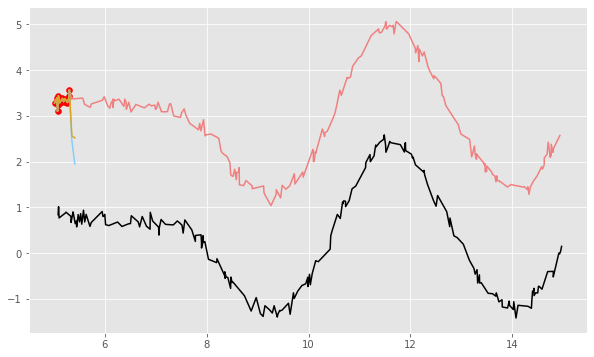

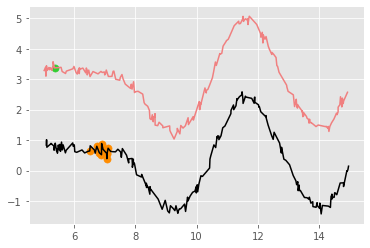

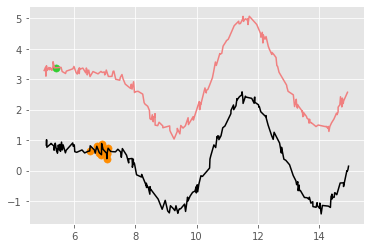

sample # 0, r squared: 0.996693097052688


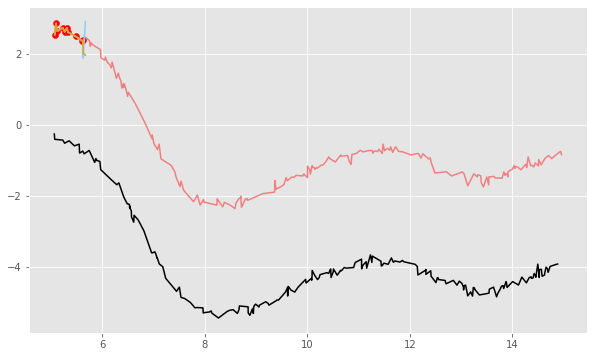

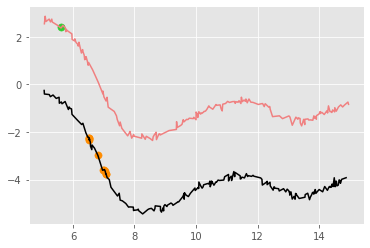

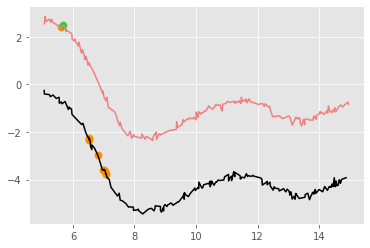

sample # 0, r squared: 0.8577841240310304


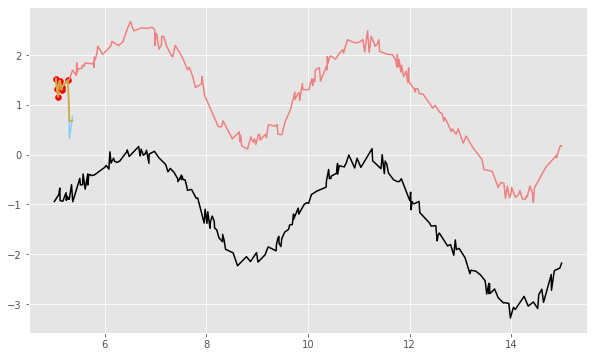

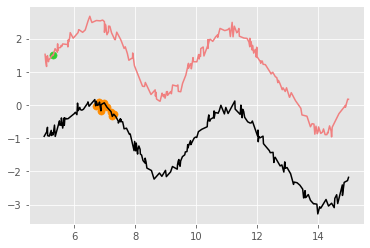

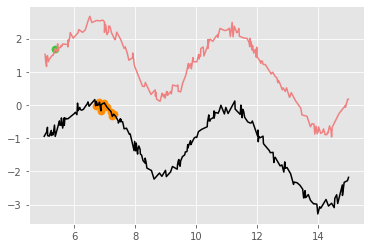

sample # 0, r squared: -0.10254340290943542


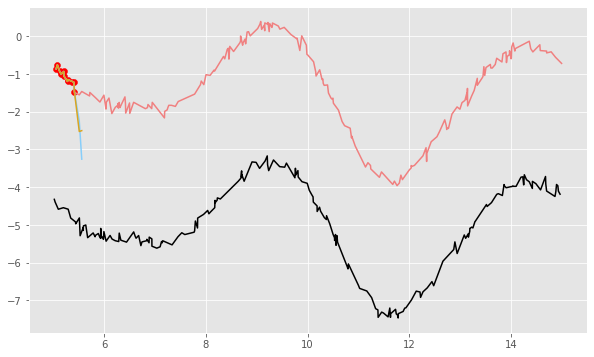

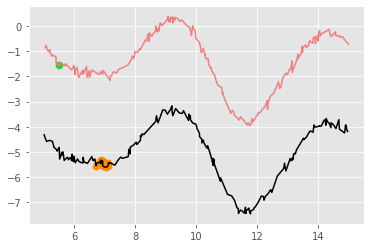

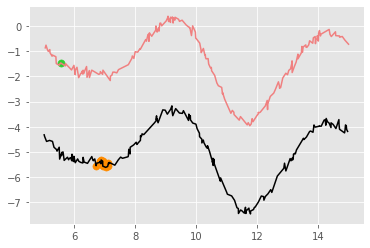

sample # 0, r squared: 0.9970613574185077


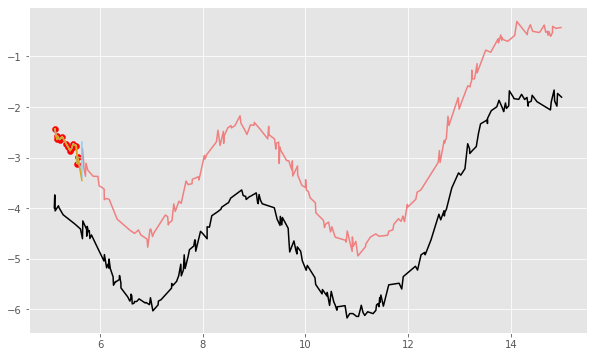

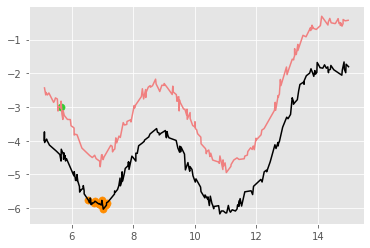

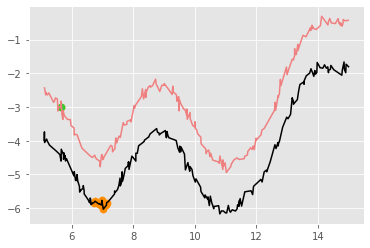

sample # 0, r squared: 0.8440068068896215


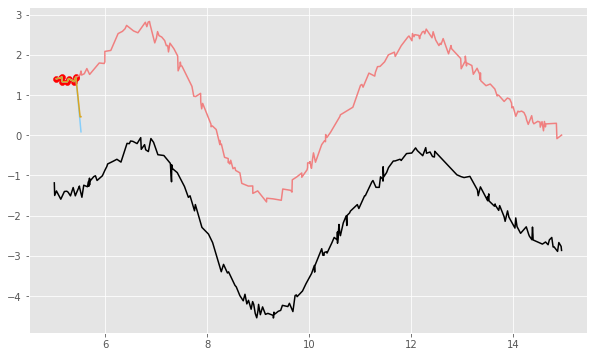

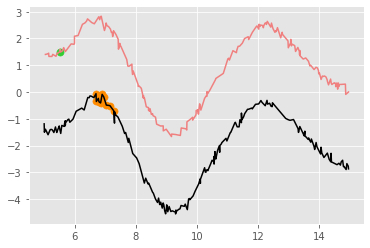

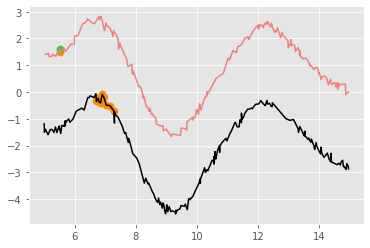

sample # 0, r squared: 0.9454960570101878


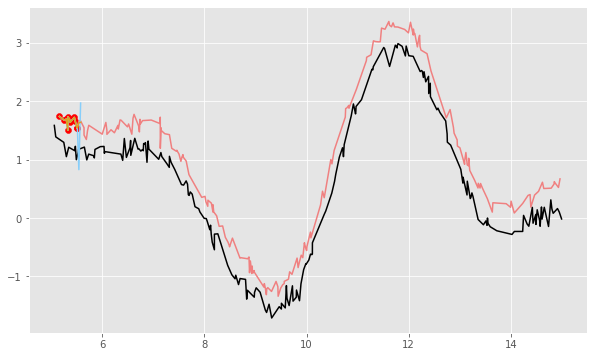

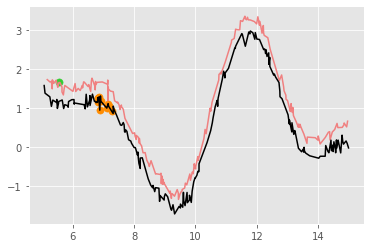

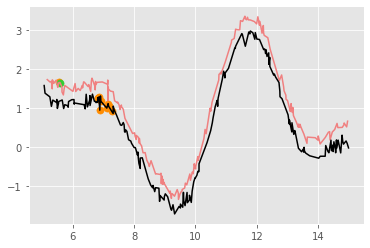

sample # 0, r squared: 0.9988258272148478


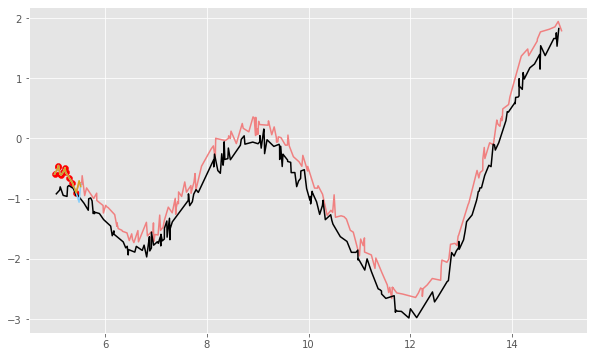

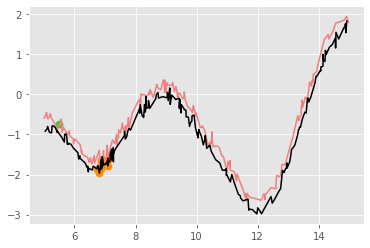

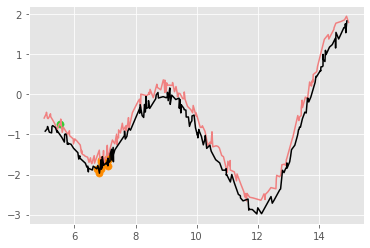

sample # 0, r squared: 0.9405144209816998


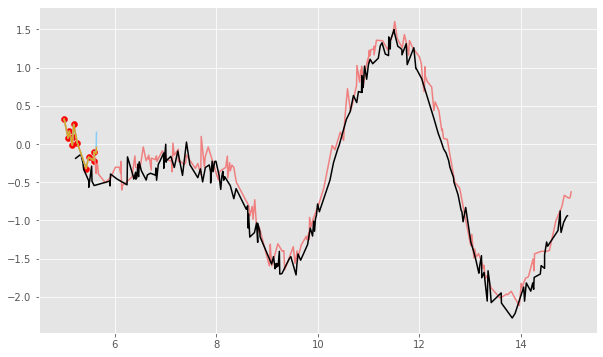

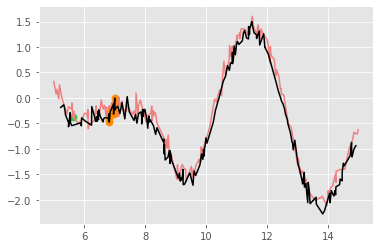

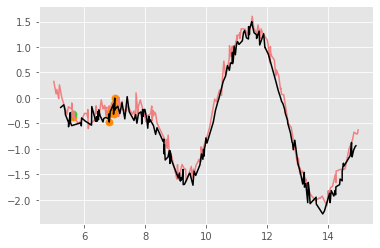

sample # 0, r squared: 0.9807115887477411


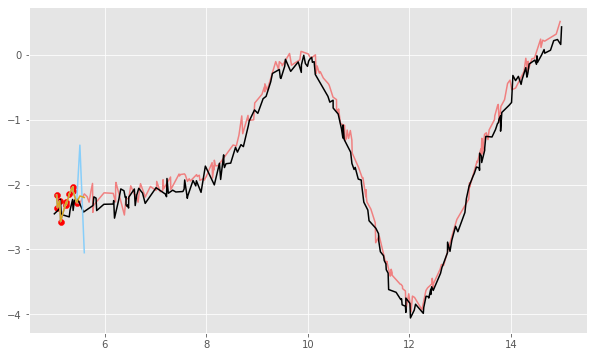

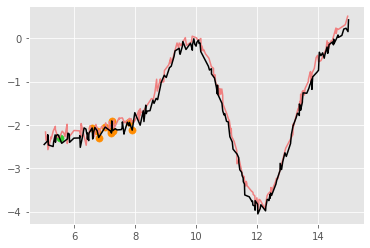

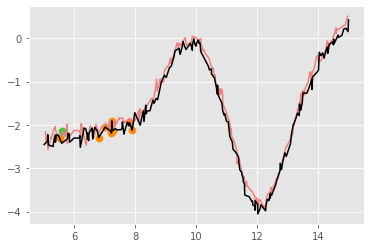

sample # 0, r squared: 0.9522446502481374


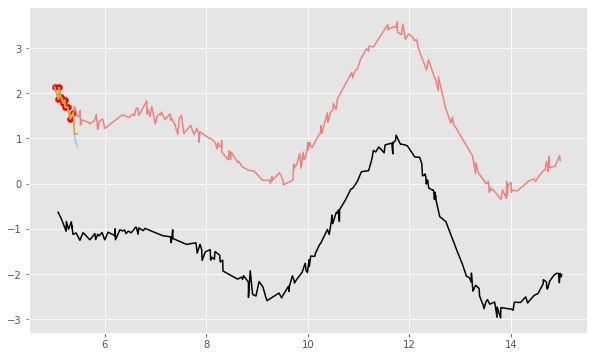

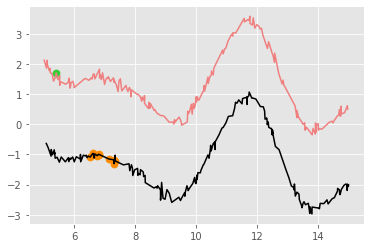

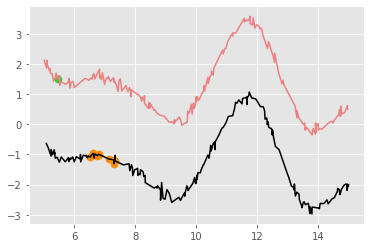

sample # 0, r squared: 0.9991538985383253


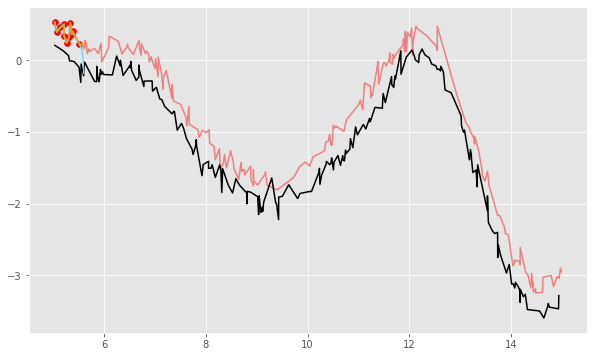

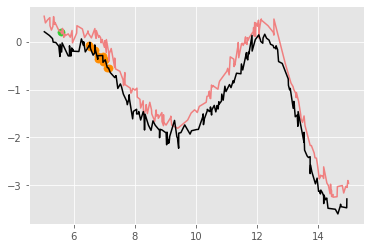

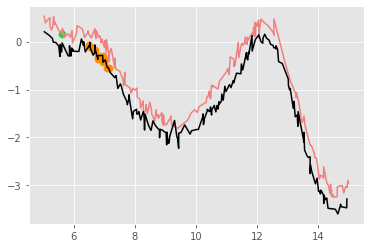

sample # 0, r squared: 0.9949524525739821


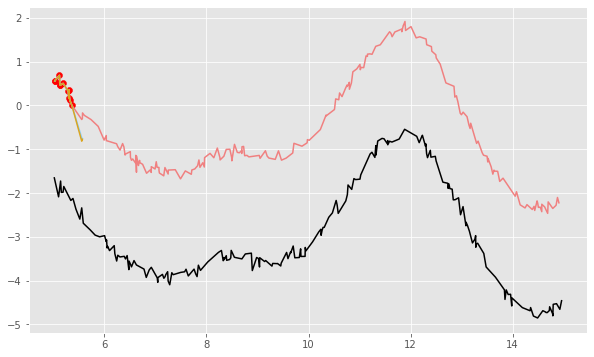

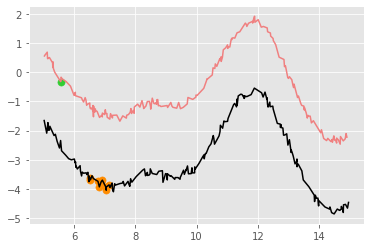

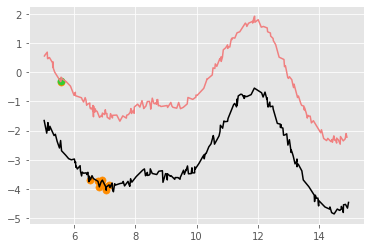

sample # 0, r squared: -2.083373668979999


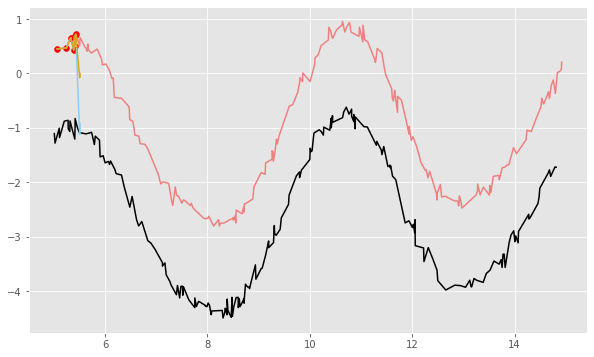

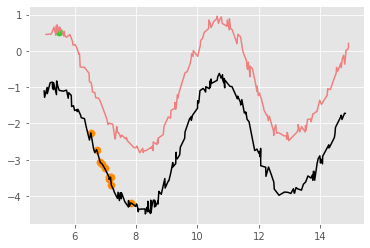

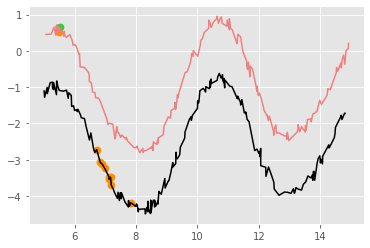

sample # 0, r squared: 0.9743489631365954


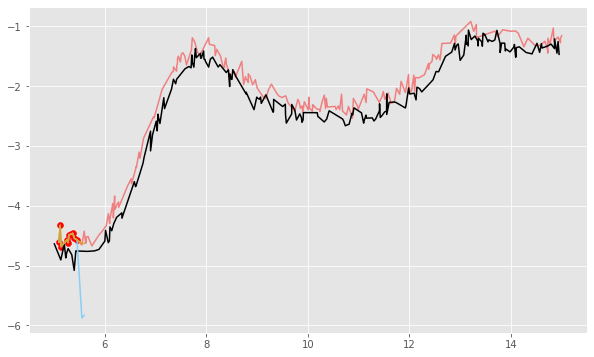

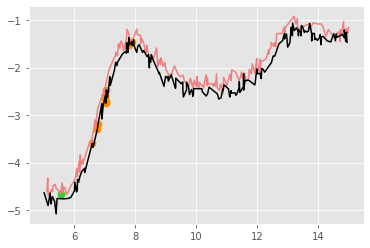

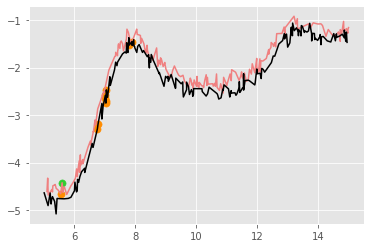

sample # 0, r squared: 0.9999171433889977


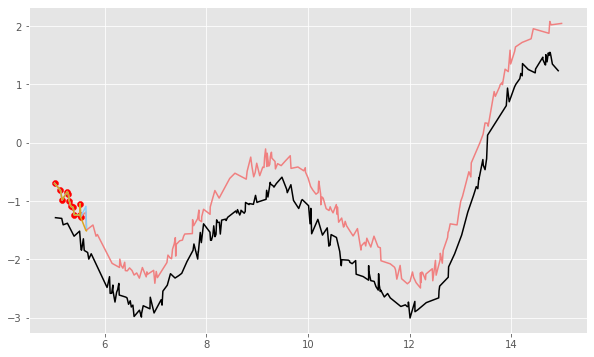

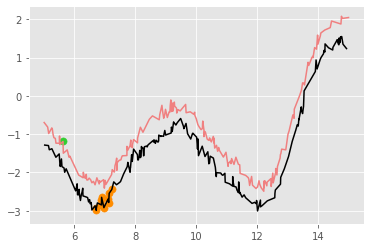

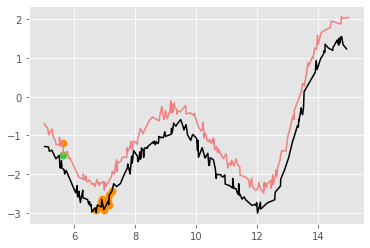

sample # 0, r squared: 0.990055978498569


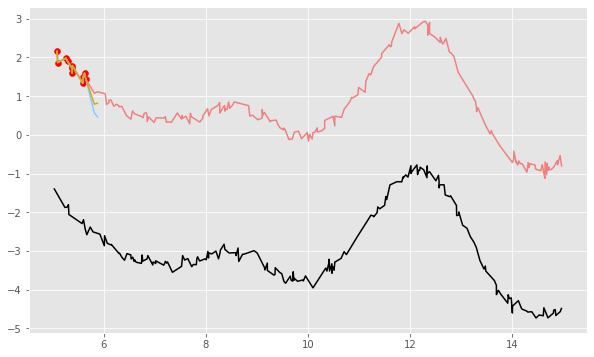

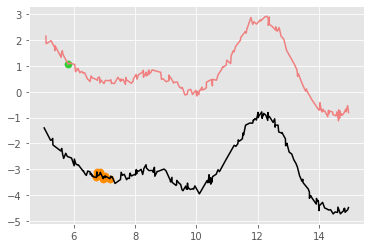

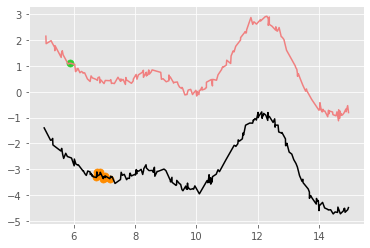

sample # 0, r squared: 0.3660349972384974


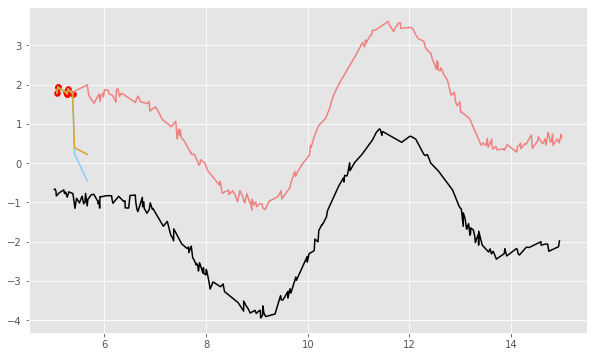

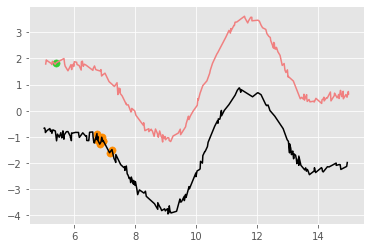

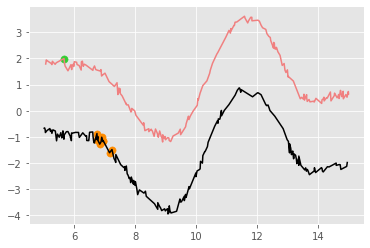

sample # 0, r squared: 0.9440766644502804


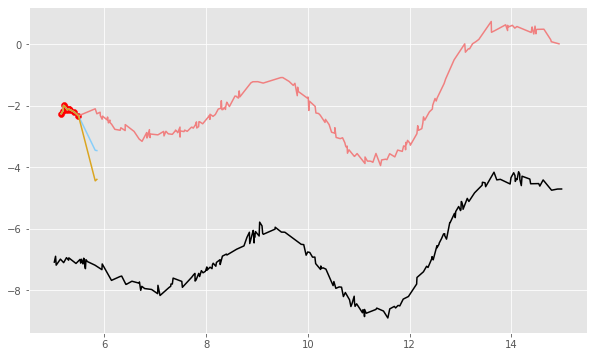

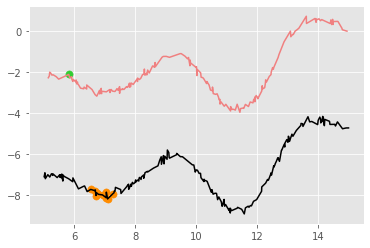

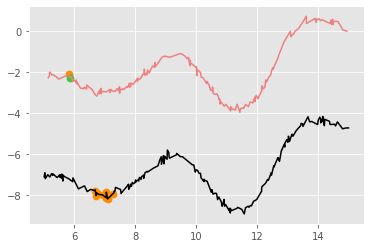

sample # 0, r squared: 0.9398150917440804


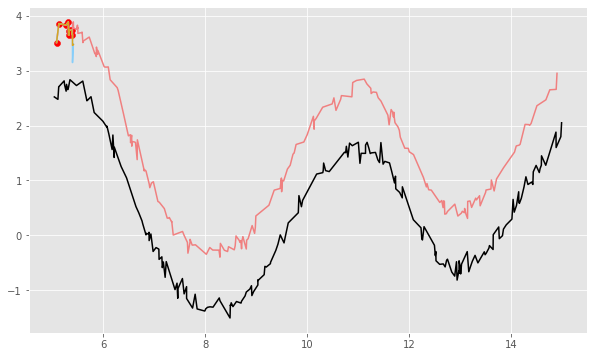

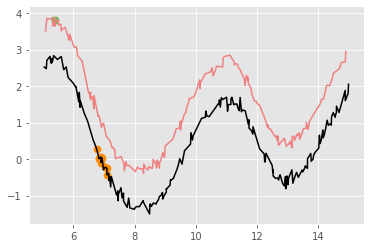

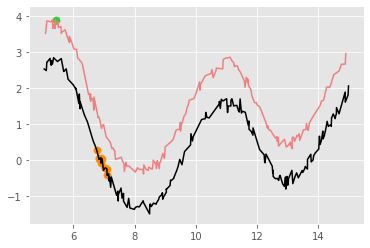

sample # 0, r squared: 0.9766678749757697


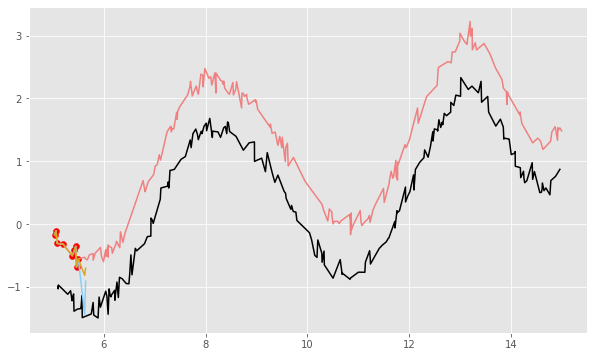

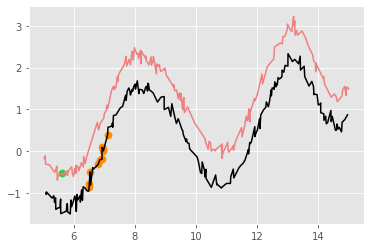

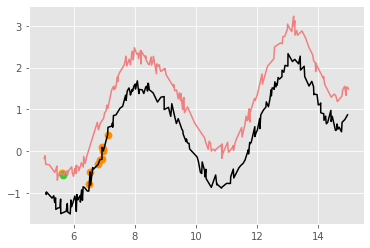

sample # 0, r squared: 0.9690627000915192


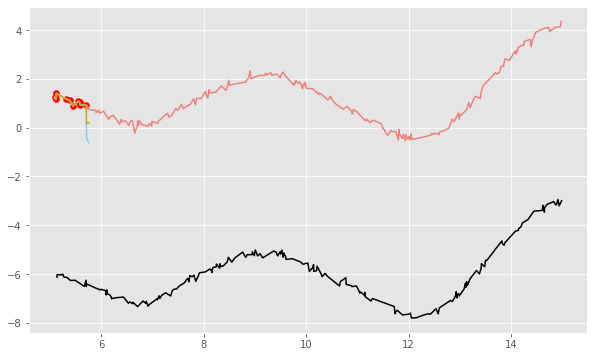

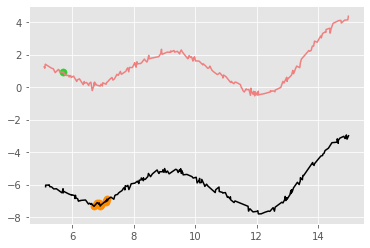

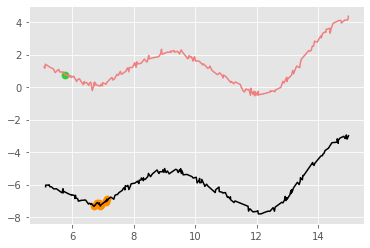

sample # 0, r squared: 0.9051128640869537


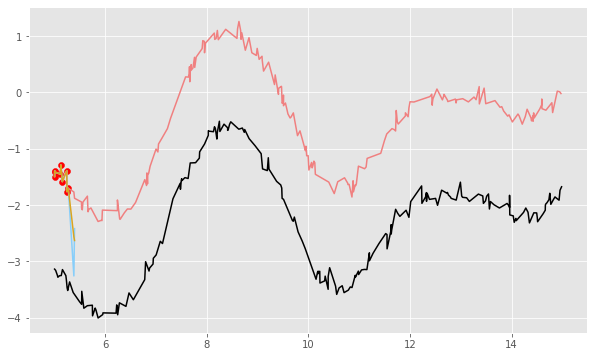

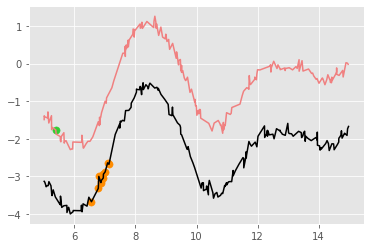

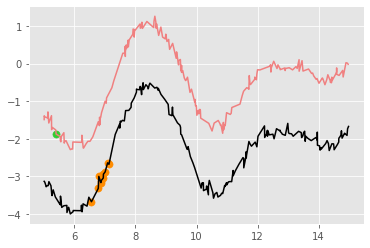

sample # 0, r squared: -0.32573848387180915


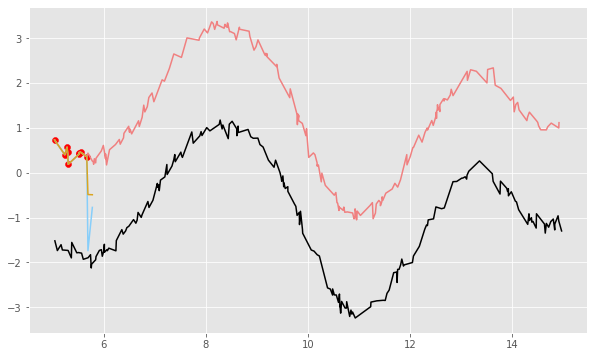

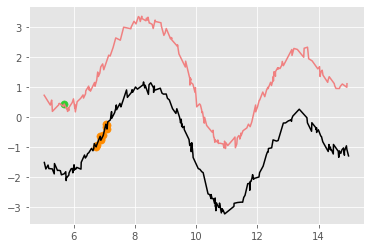

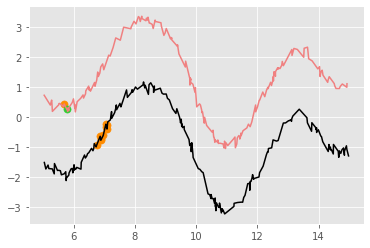

sample # 0, r squared: 0.9921664837616017


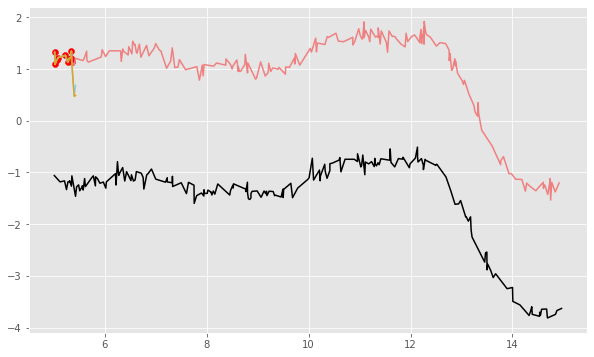

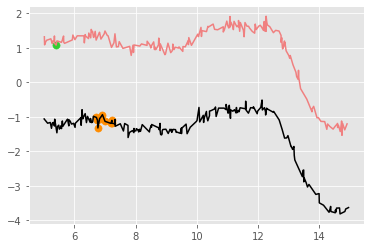

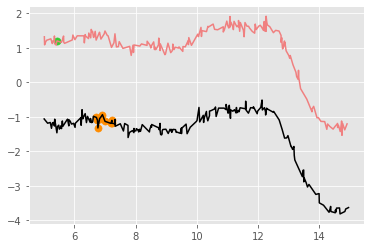

sample # 0, r squared: -1.1346841029132246


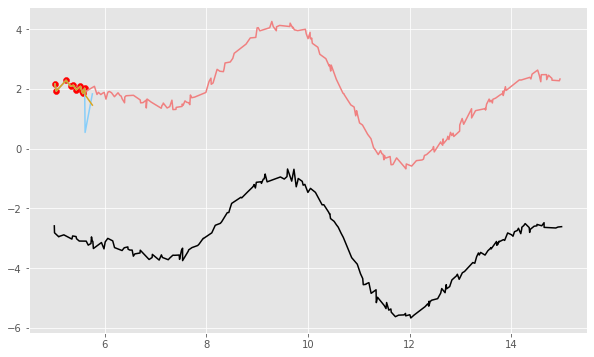

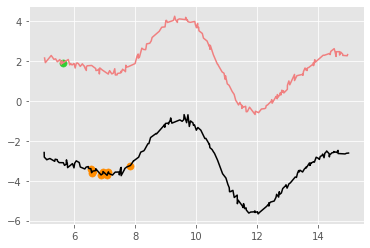

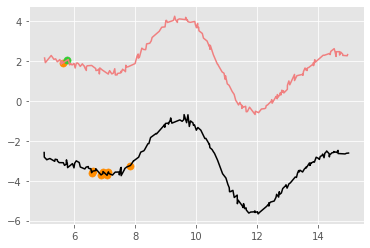

sample # 0, r squared: 0.9342865126986559


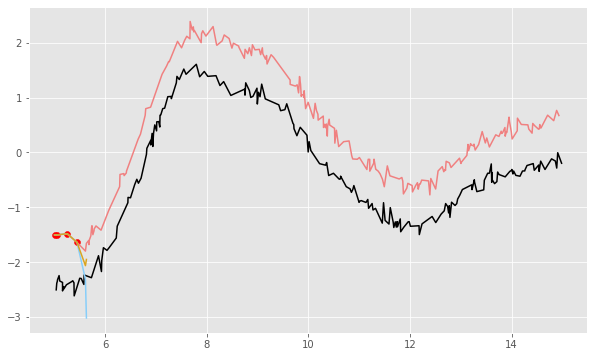

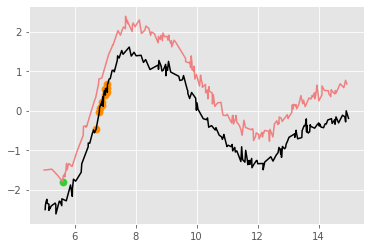

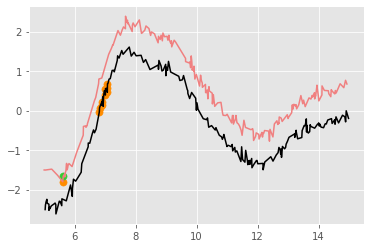

sample # 0, r squared: 0.9920701709716212


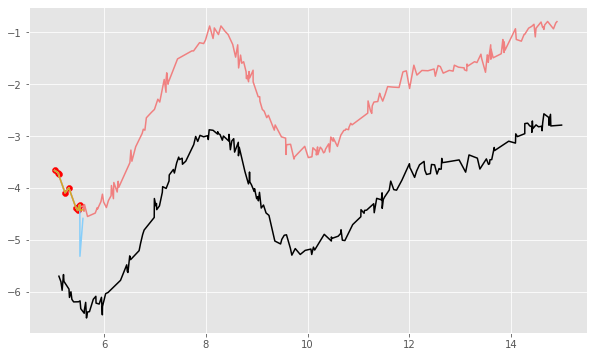

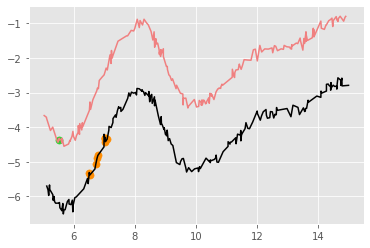

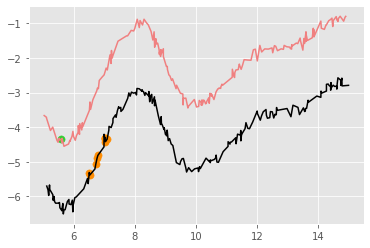

sample # 0, r squared: 0.9484874902764199


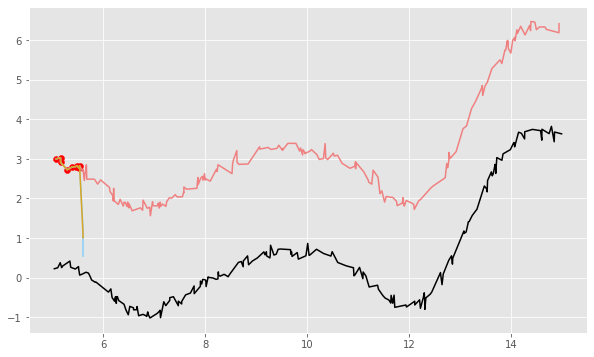

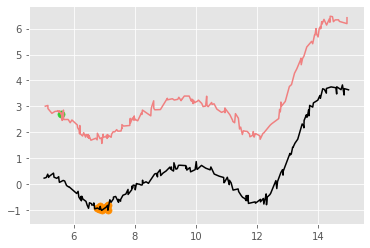

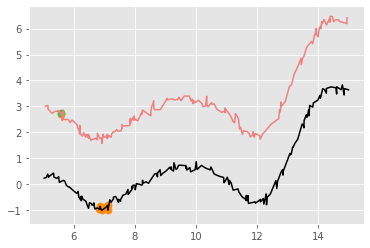

sample # 0, r squared: 0.9973006495310922


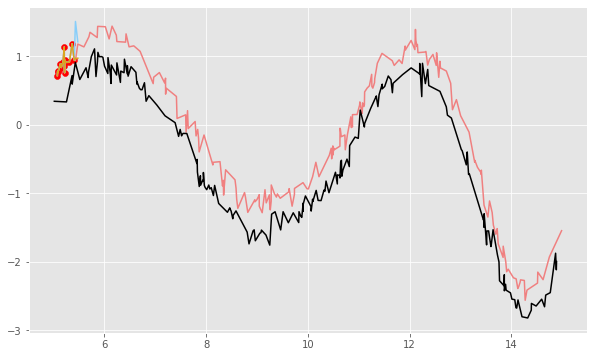

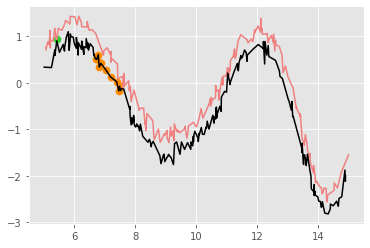

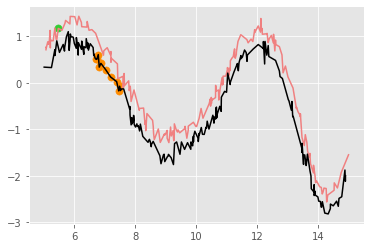

sample # 0, r squared: 0.9334406430208535


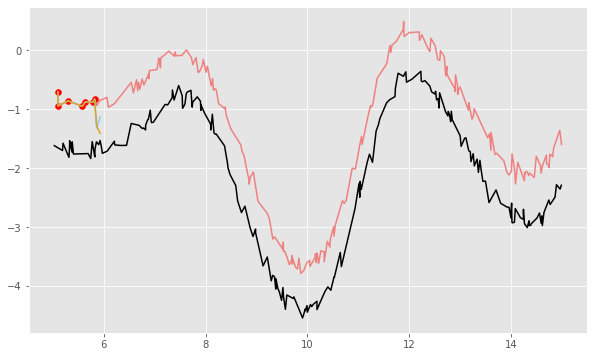

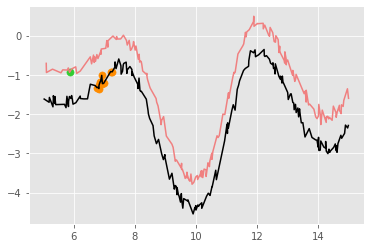

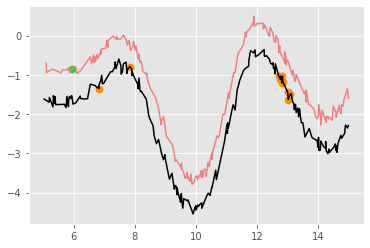

sample # 0, r squared: 0.373255830377742


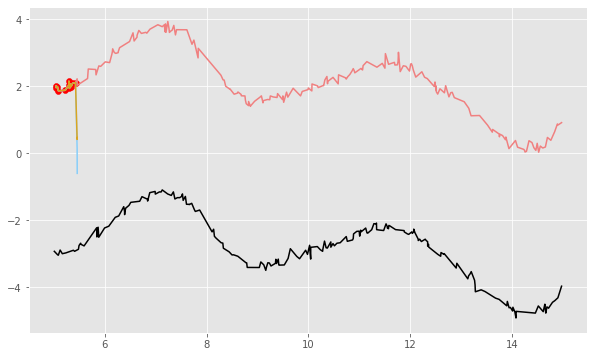

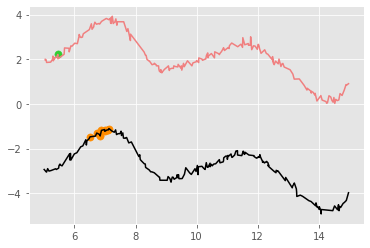

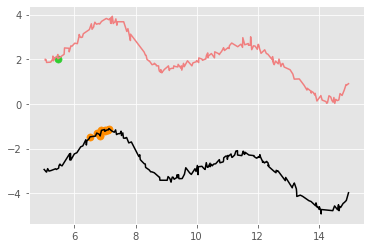

sample # 0, r squared: 0.9963864321159593


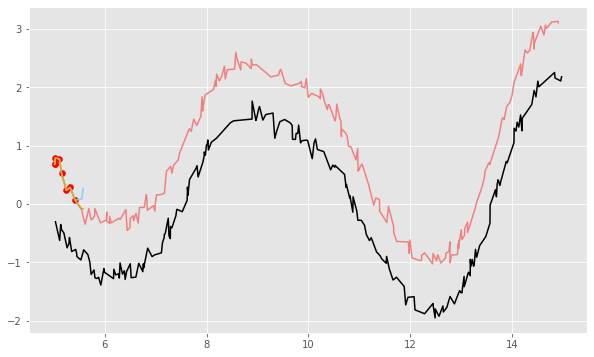

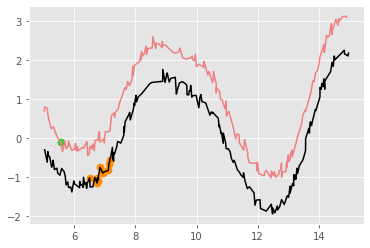

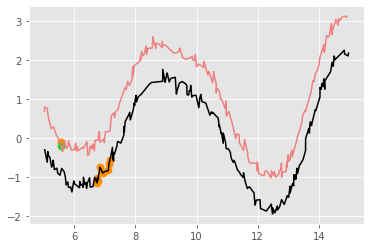

sample # 0, r squared: 0.870053063252161


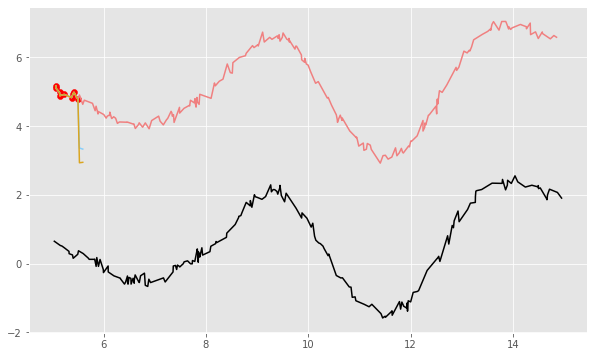

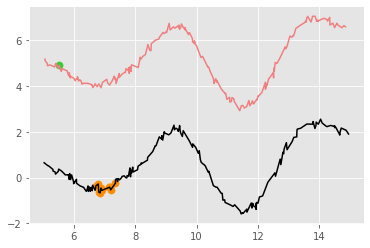

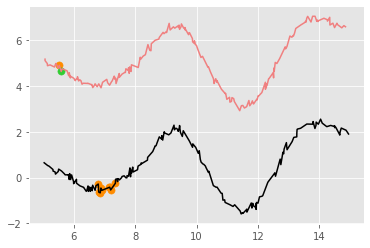

sample # 0, r squared: 0.9200788334144513


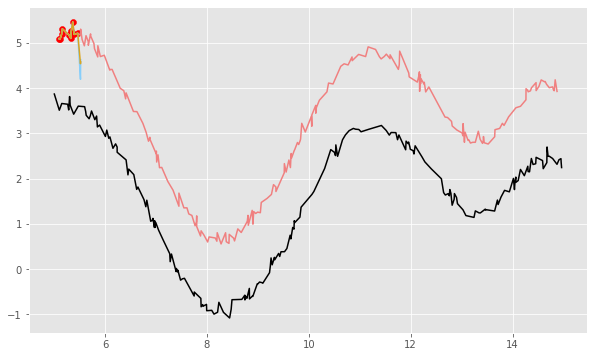

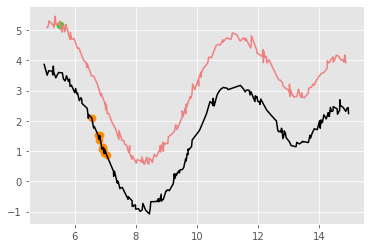

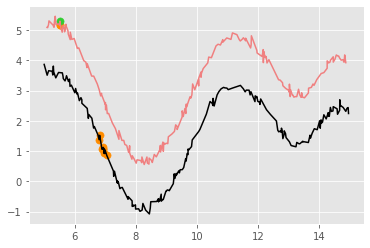

sample # 0, r squared: 0.9859904672947671


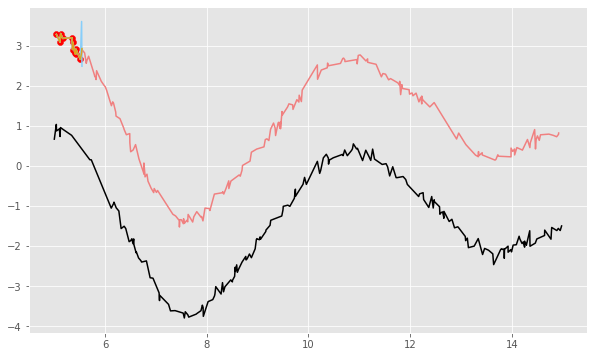

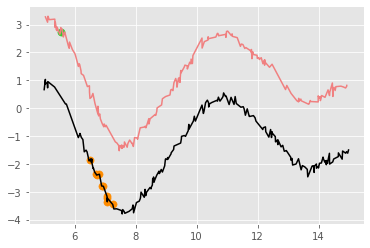

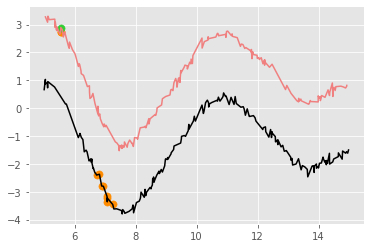

sample # 0, r squared: 0.9891933861987907


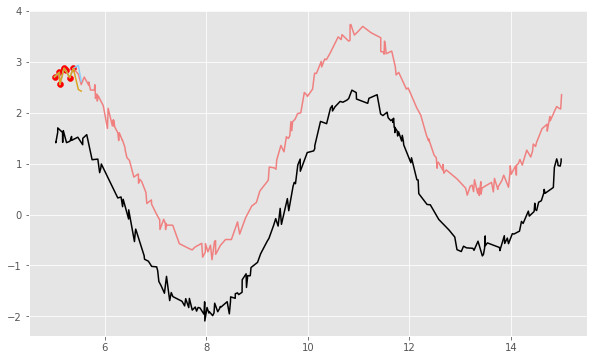

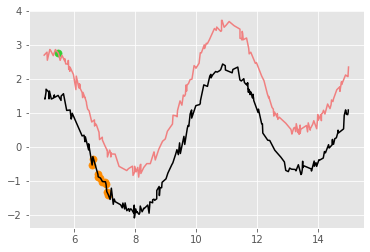

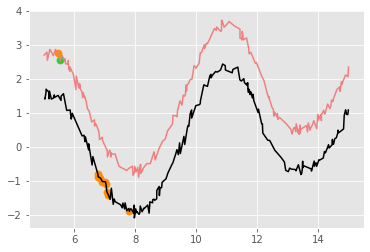

sample # 0, r squared: 0.9899743121796457


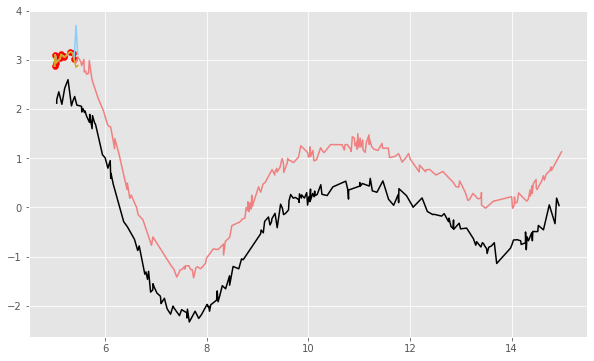

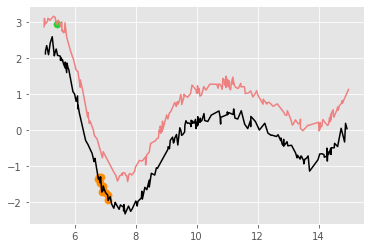

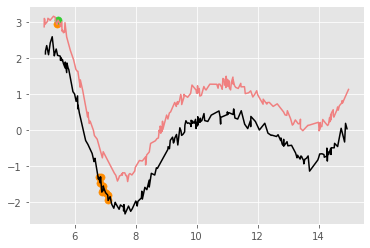

sample # 0, r squared: 0.9878415699091526


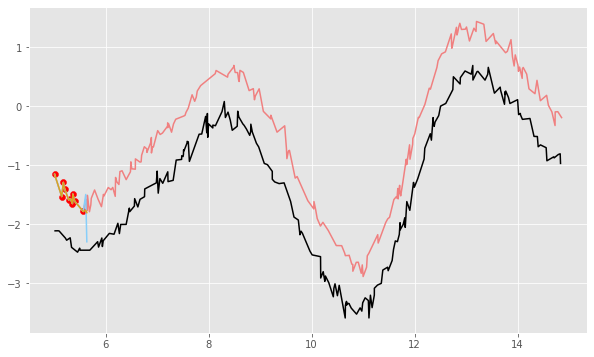

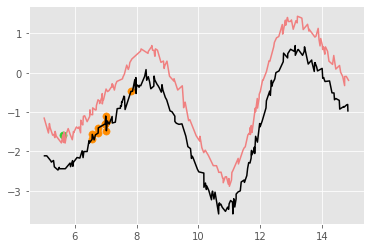

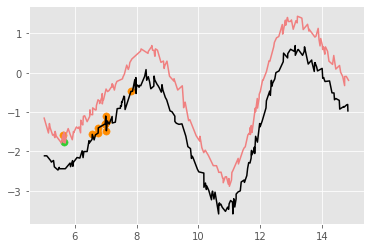

sample # 0, r squared: 0.956207453845717


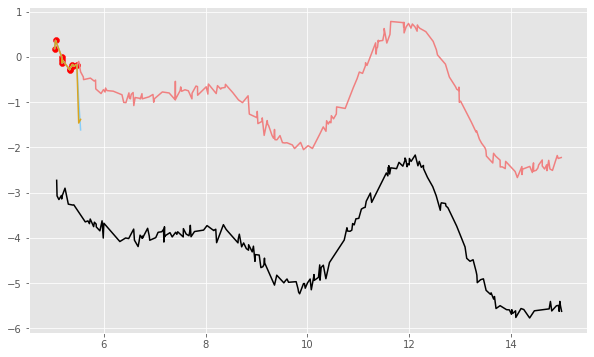

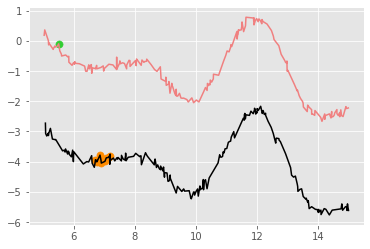

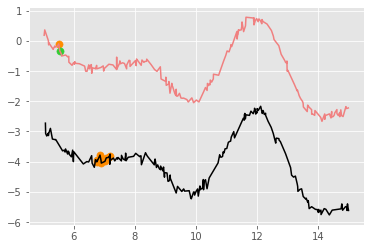

sample # 0, r squared: 0.9854918805311258


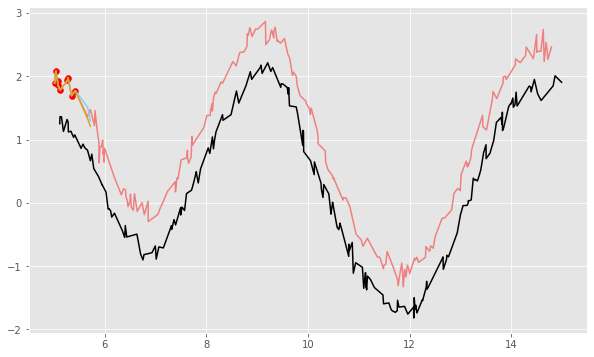

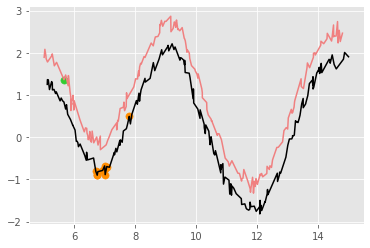

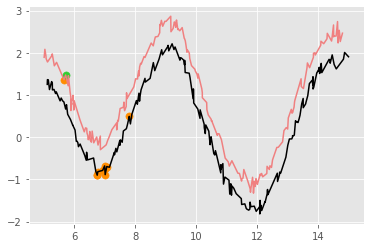

sample # 0, r squared: 0.954539304007483


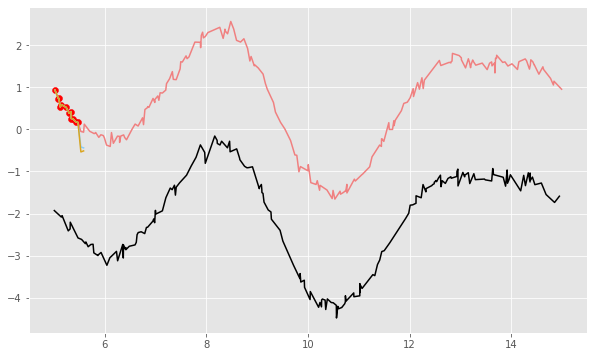

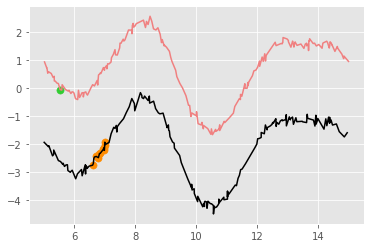

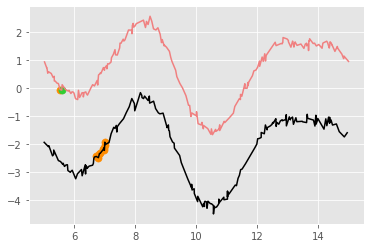

sample # 0, r squared: 0.2859935714684462


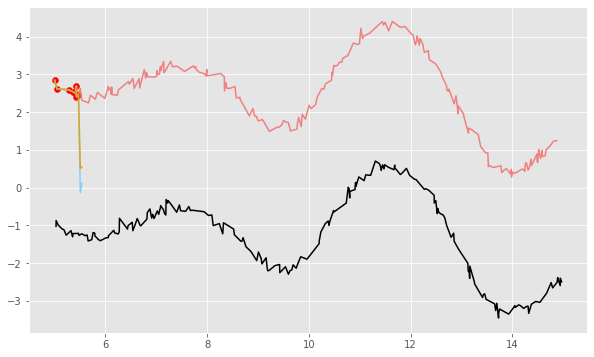

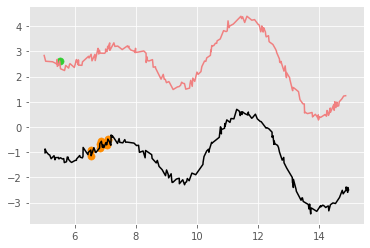

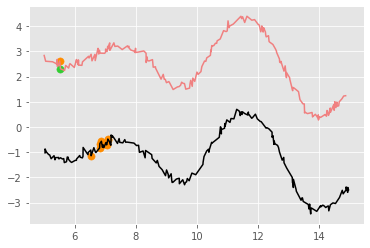

sample # 0, r squared: 0.9419191909520309


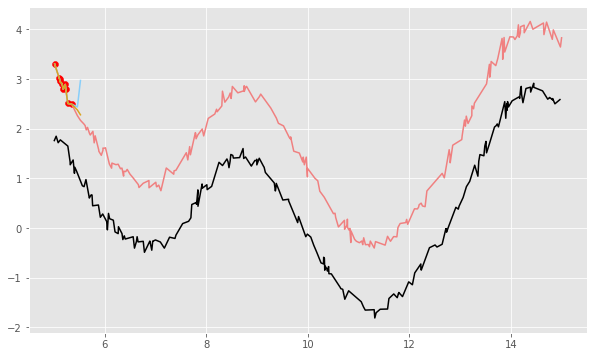

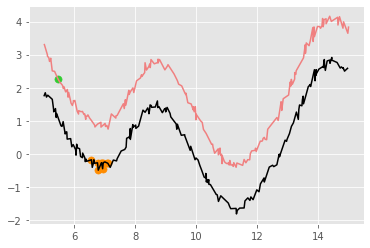

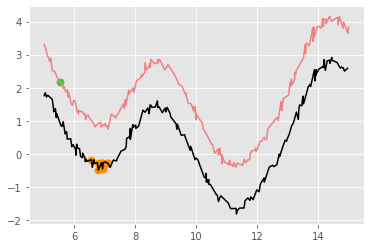

sample # 0, r squared: 0.9864728050574544


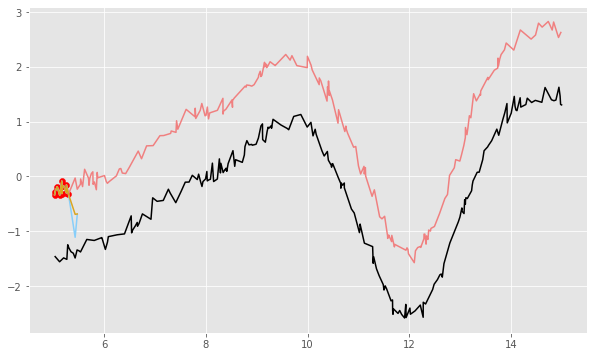

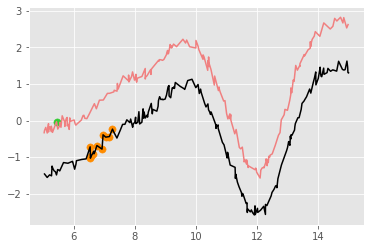

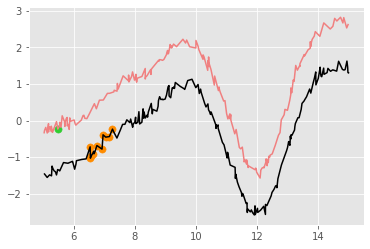

sample # 0, r squared: 0.44020696990656194


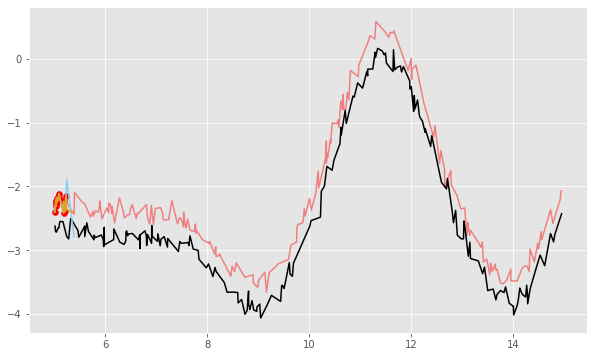

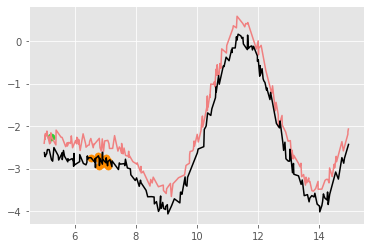

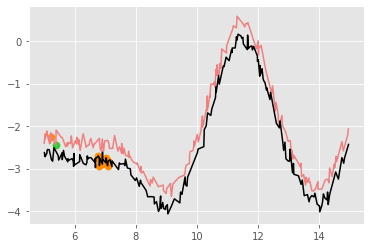

sample # 0, r squared: 0.6497586758931115


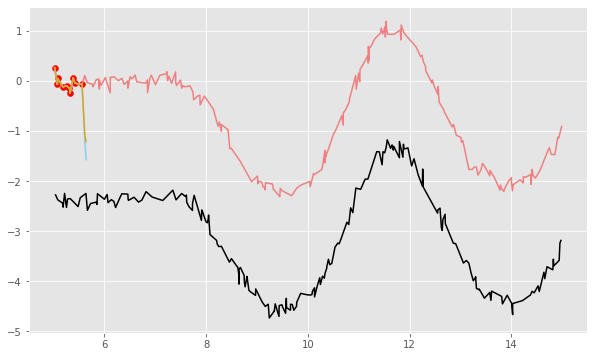

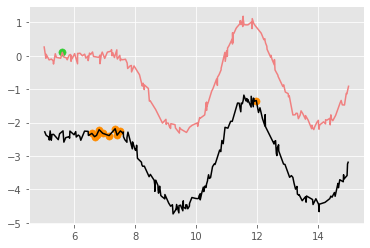

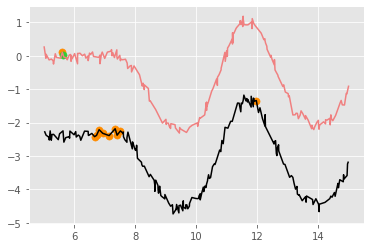

sample # 0, r squared: 0.9992639969719296


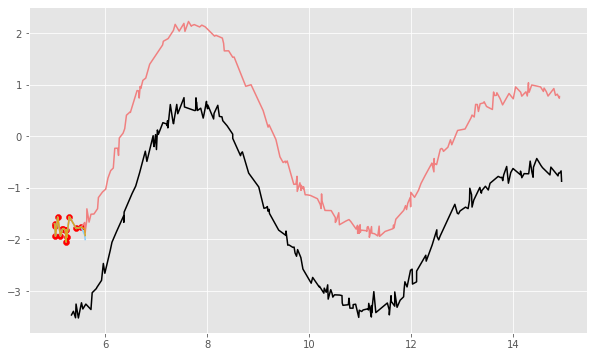

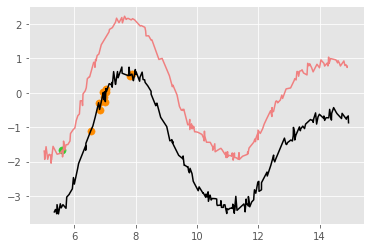

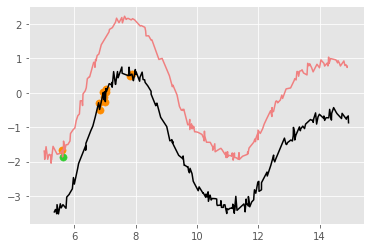

sample # 0, r squared: 0.8716318097234437


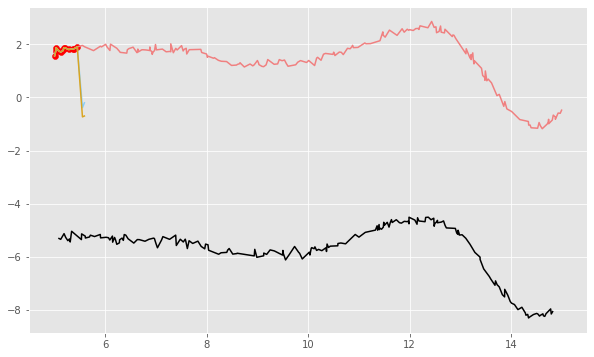

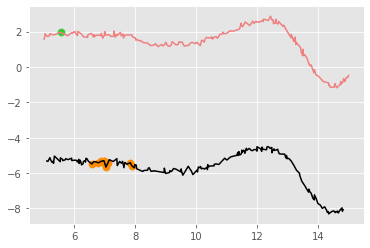

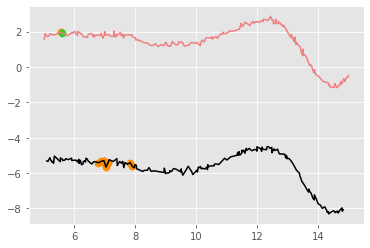

sample # 0, r squared: 0.9826976897496511


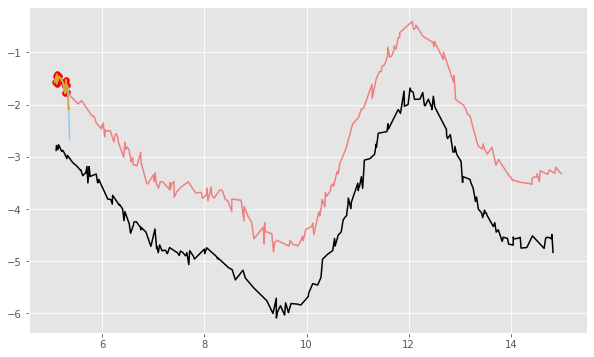

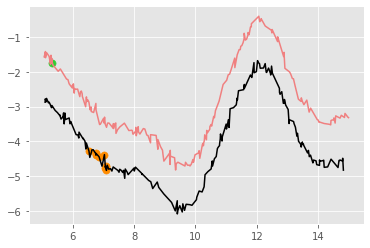

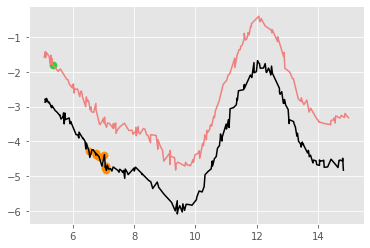

sample # 0, r squared: 0.9553047628097696


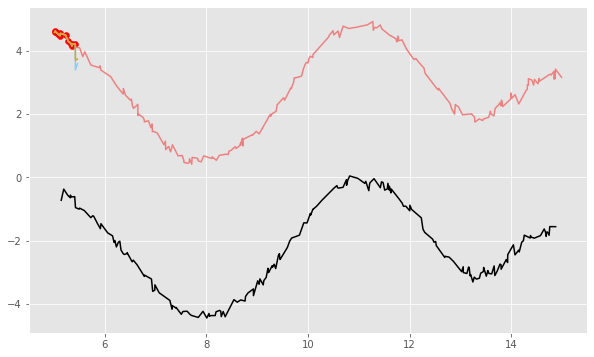

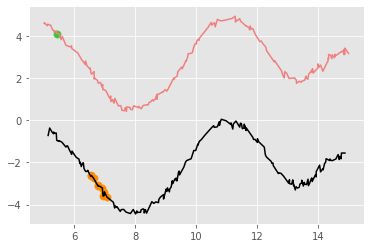

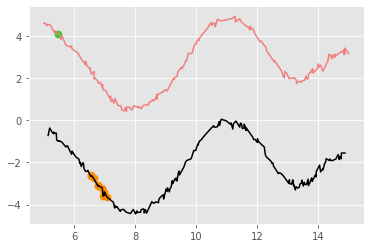

sample # 0, r squared: 0.9253089043482442


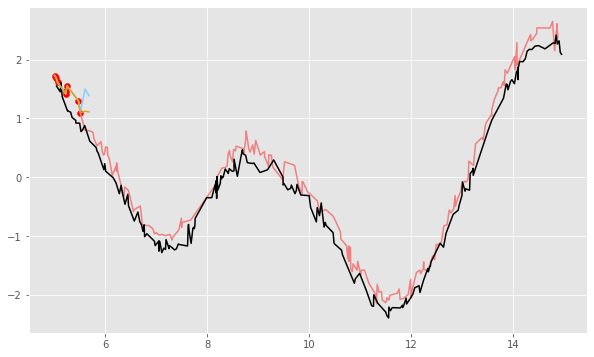

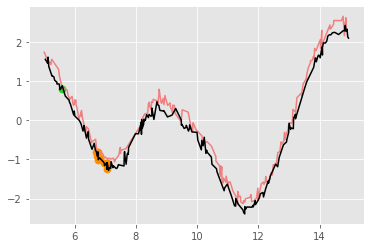

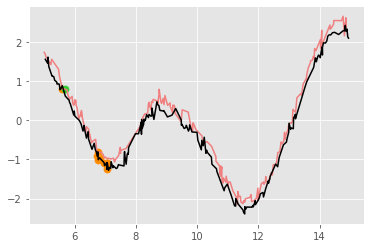

sample # 0, r squared: 0.9825871677562998


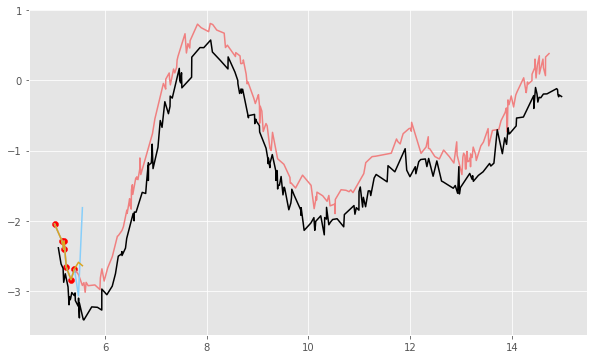

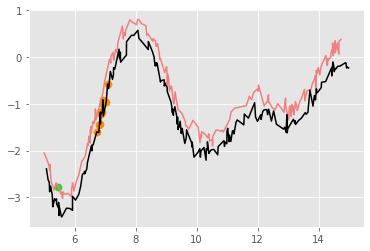

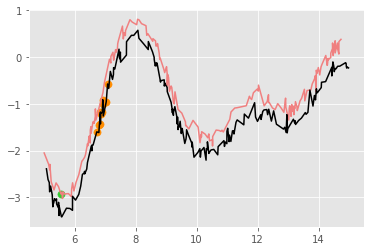

sample # 0, r squared: 0.9556474731099159


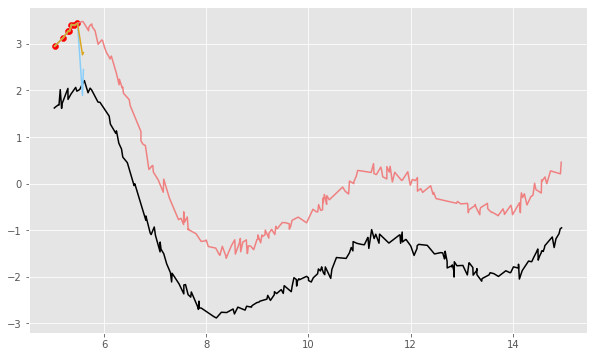

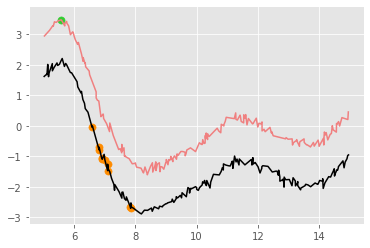

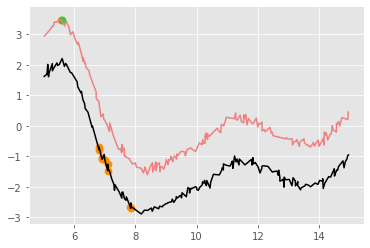

sample # 0, r squared: 0.832320878682829


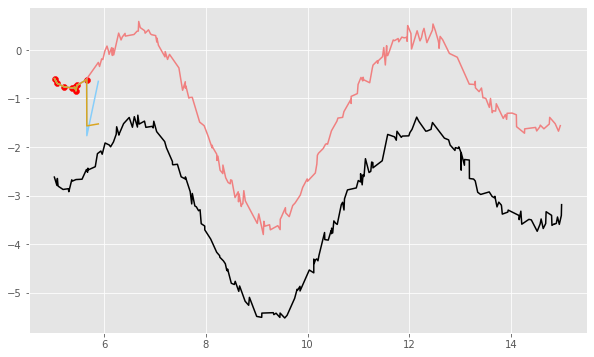

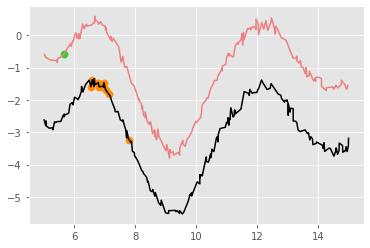

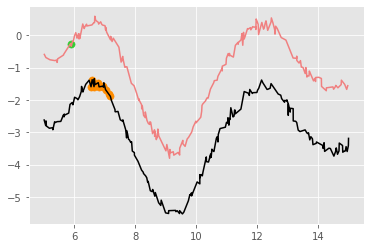

sample # 0, r squared: 0.981829802321848


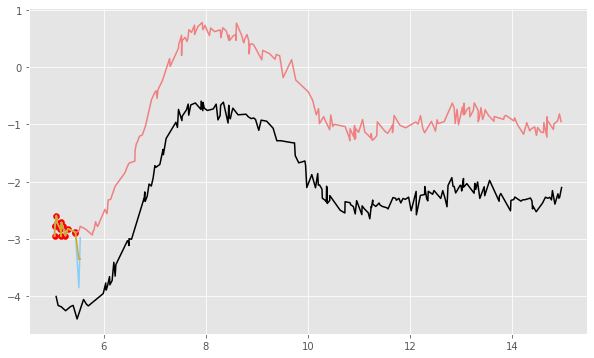

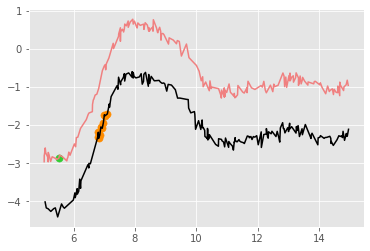

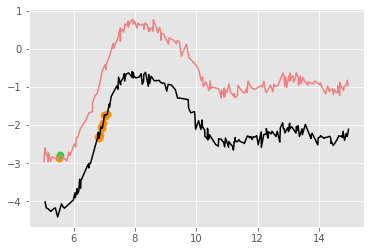

sample # 0, r squared: 0.9962589789236899


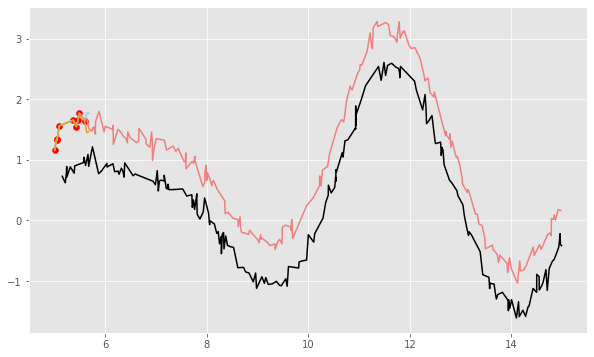

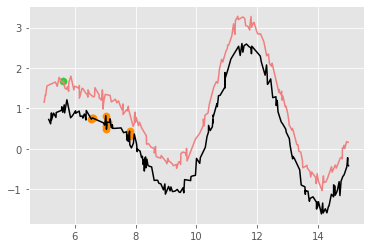

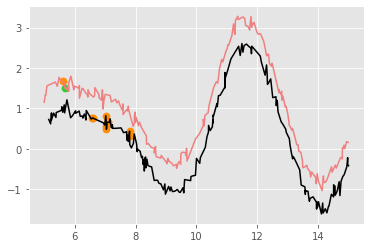

sample # 0, r squared: 0.9148658702639141


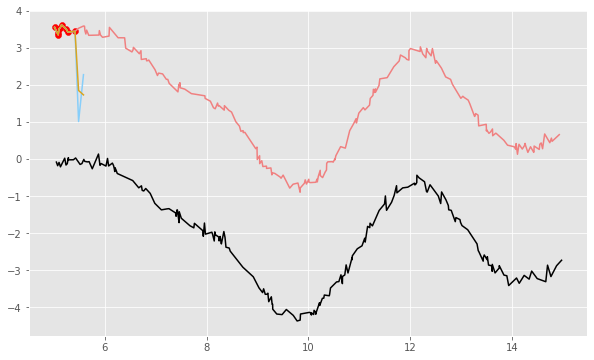

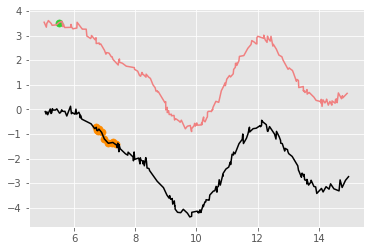

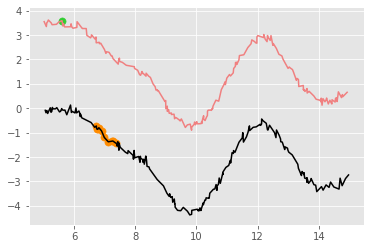

sample # 0, r squared: 0.9949415536110447


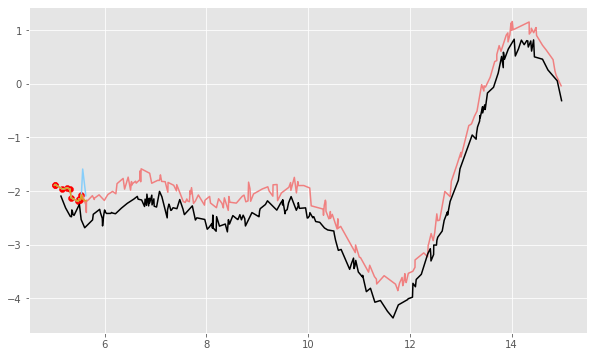

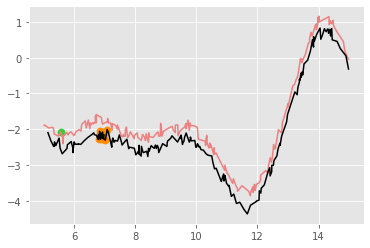

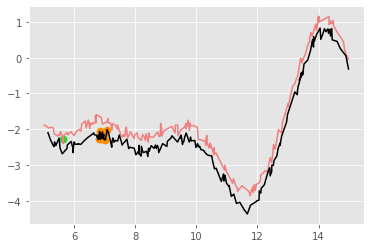

sample # 0, r squared: -0.7610529789909586


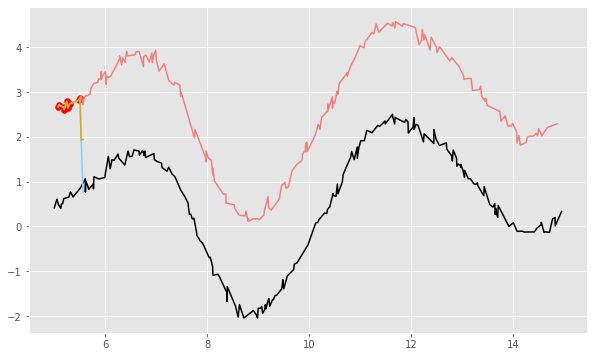

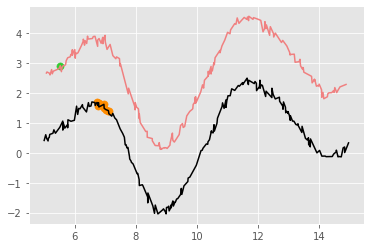

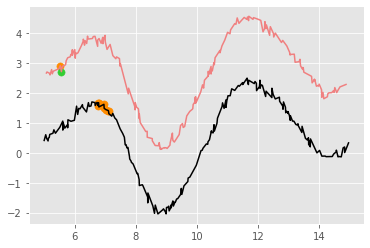

sample # 0, r squared: 0.9953335722668019


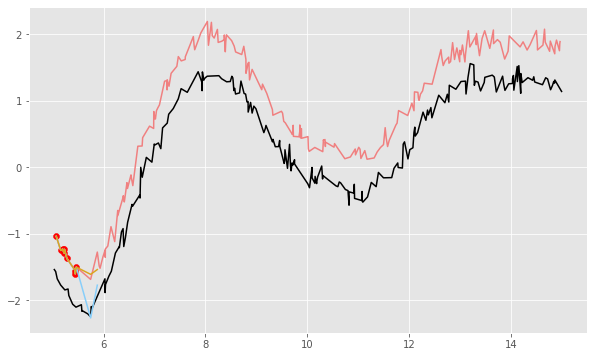

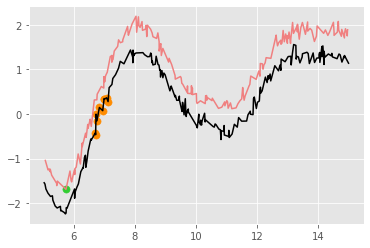

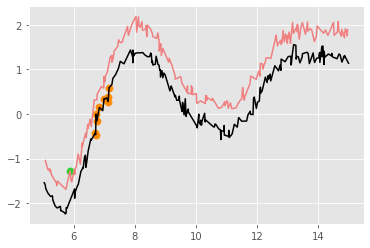

sample # 0, r squared: 0.9888537411608951


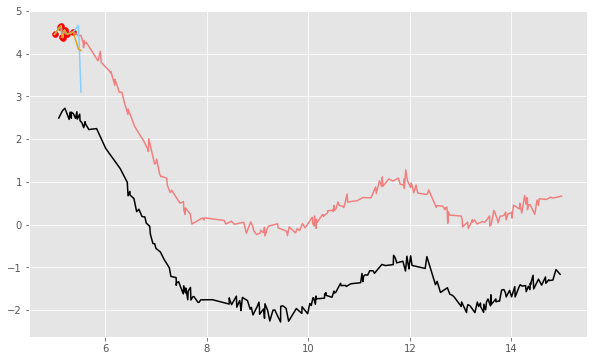

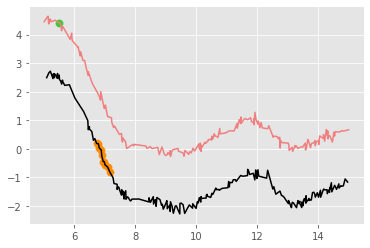

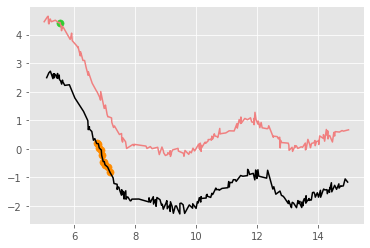

sample # 0, r squared: -0.5029680936671219


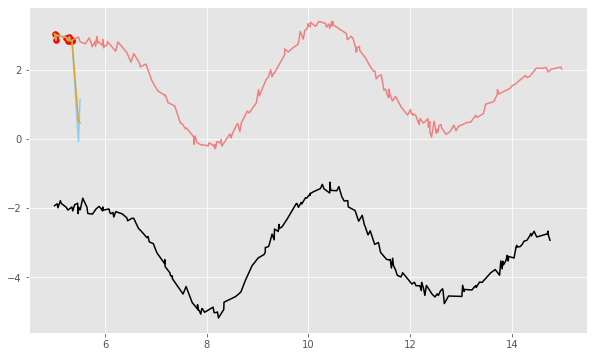

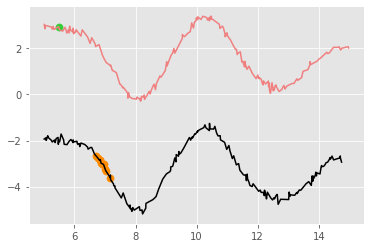

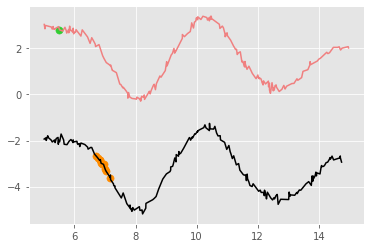

sample # 0, r squared: 0.9932896440328469


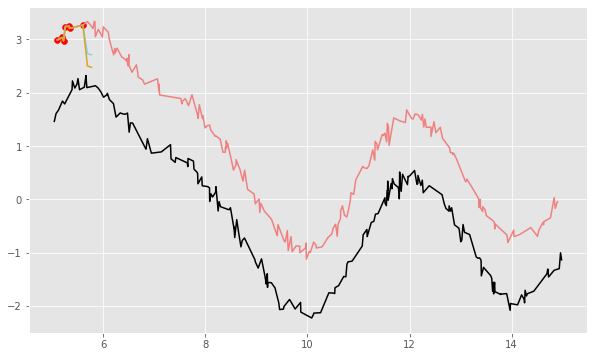

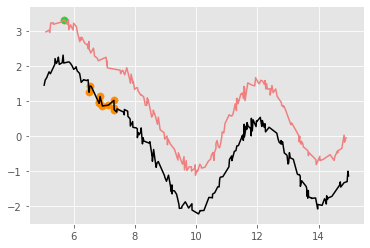

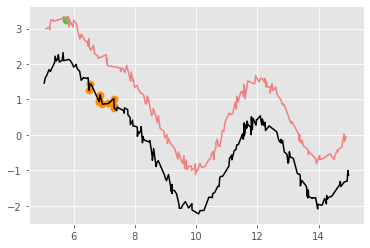

sample # 0, r squared: -1.1889841905046787


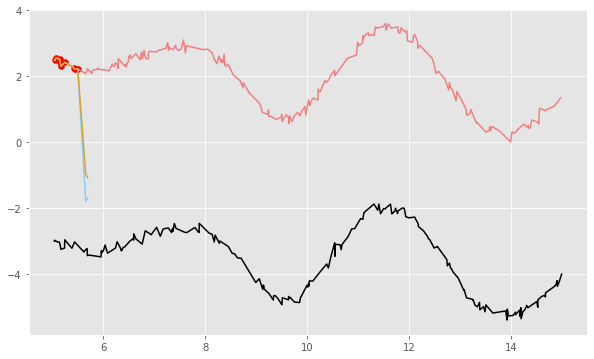

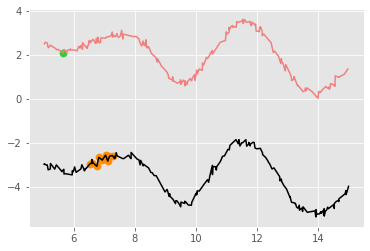

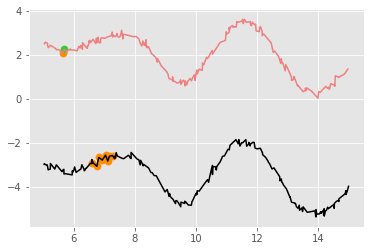

sample # 0, r squared: 0.937406491153769


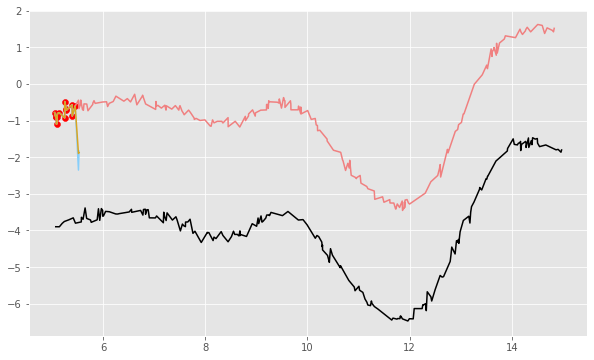

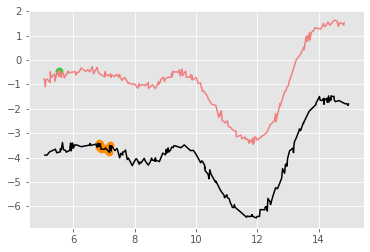

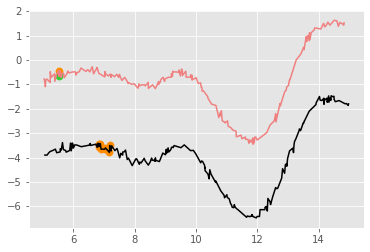

sample # 0, r squared: 0.9899731210615887


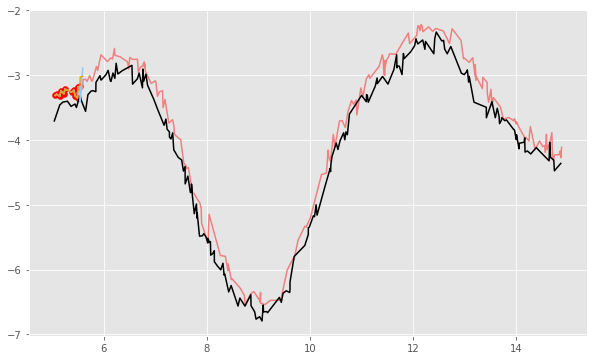

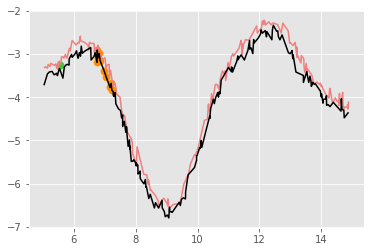

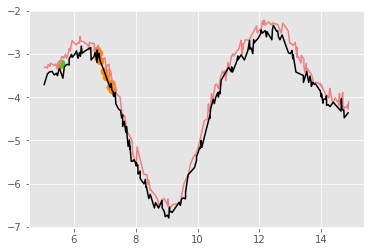

sample # 0, r squared: -0.02959081810819275


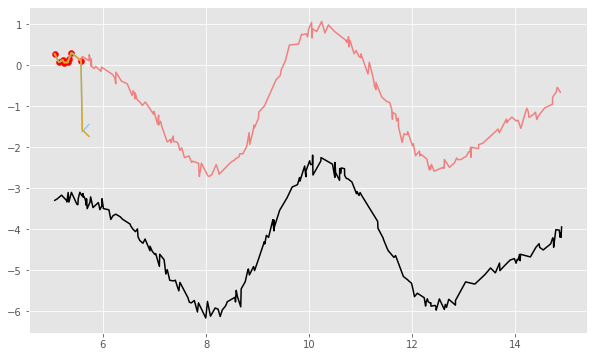

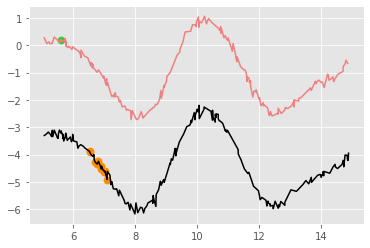

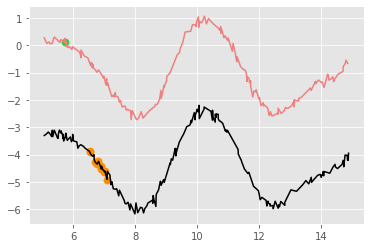

sample # 0, r squared: 0.9821838491231084


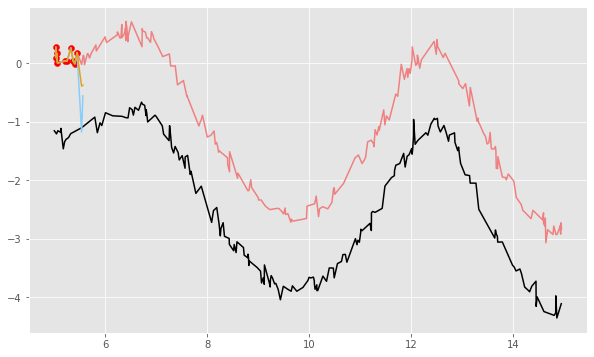

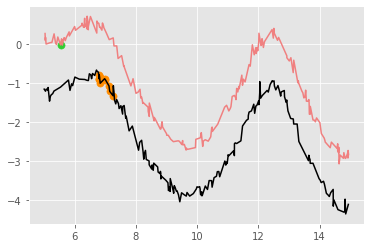

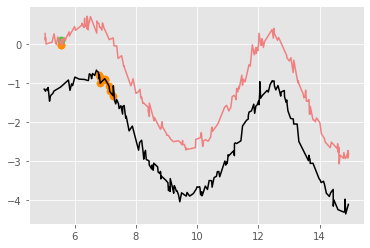

sample # 0, r squared: 0.9996369432317606


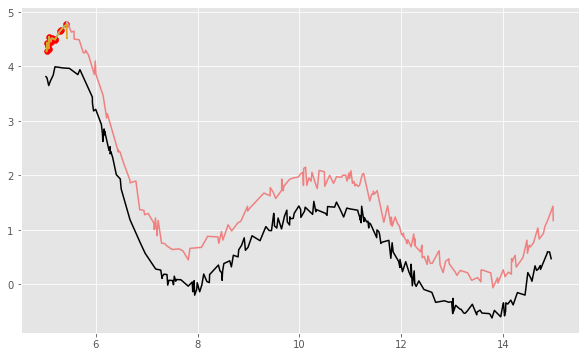

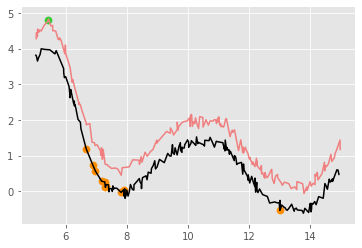

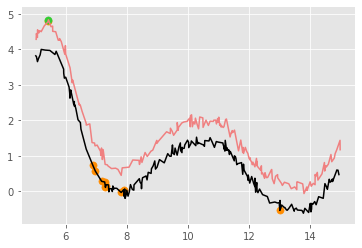

sample # 0, r squared: 0.9925736294614091


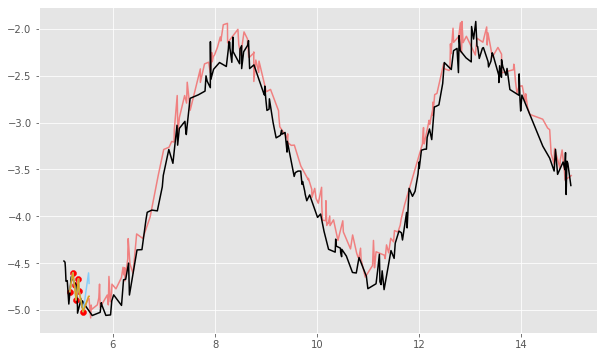

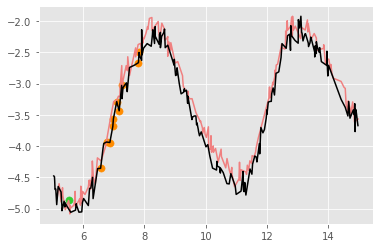

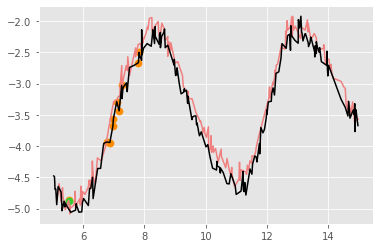

sample # 0, r squared: 0.9507904548588241


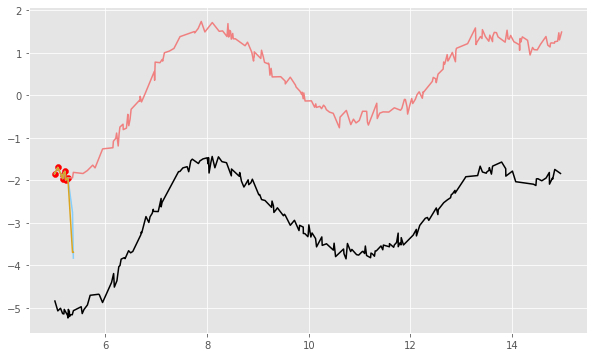

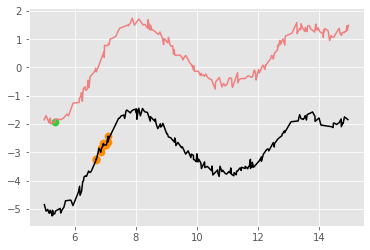

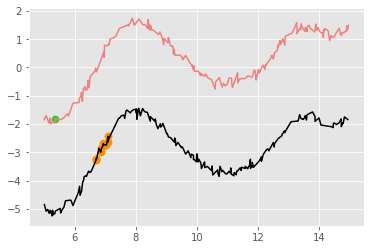

sample # 0, r squared: 0.8943937776525417


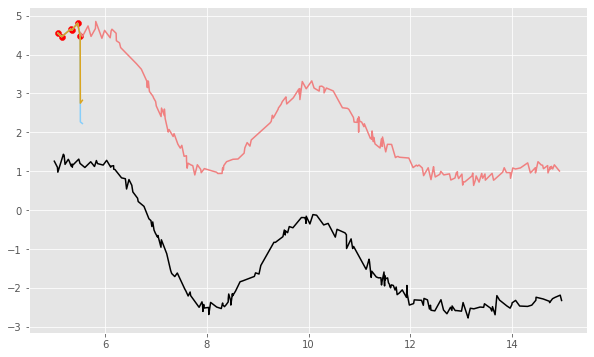

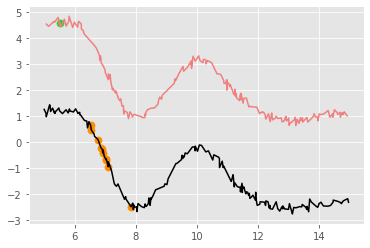

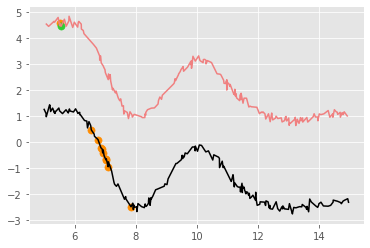

sample # 0, r squared: 0.9944715823822617


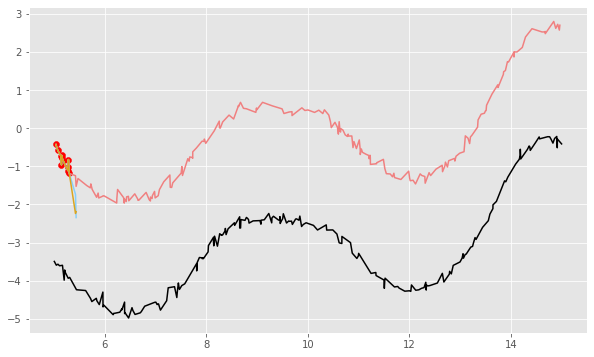

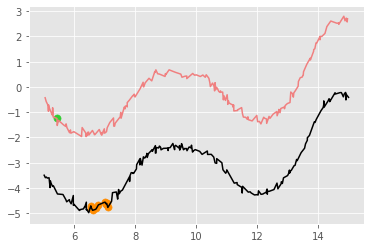

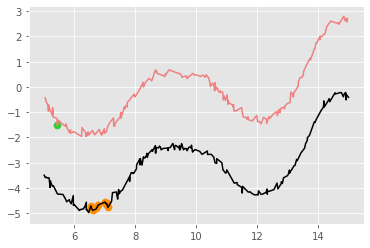

sample # 0, r squared: 0.9941418771893674


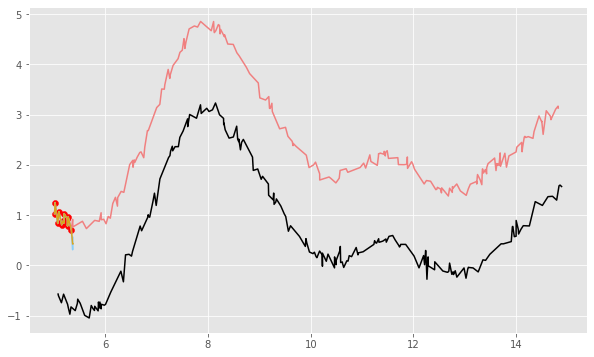

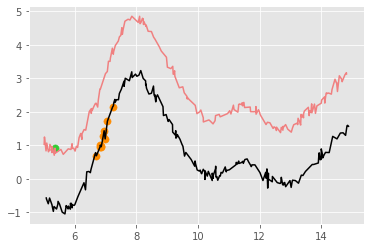

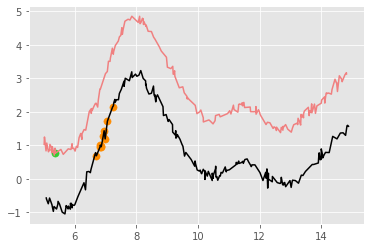

sample # 0, r squared: 0.8082895716196733


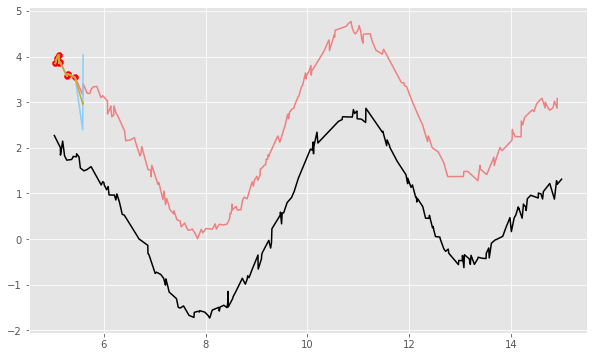

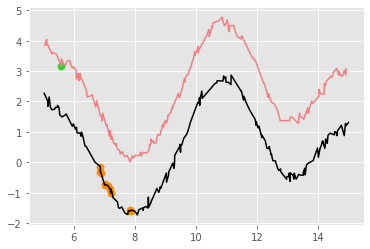

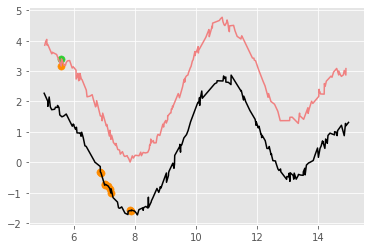

sample # 0, r squared: 0.9951559013864516


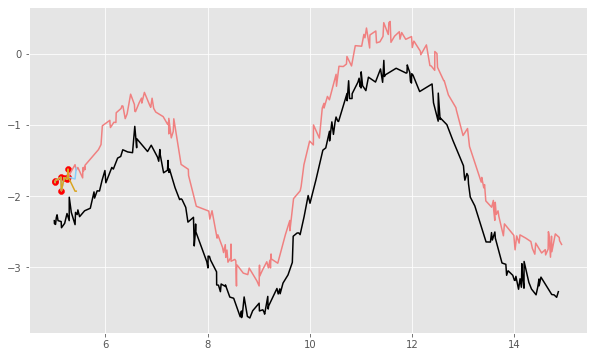

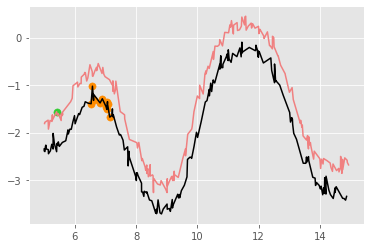

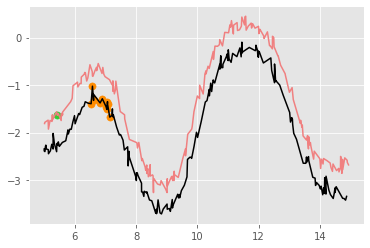

sample # 0, r squared: 0.35958099194025517


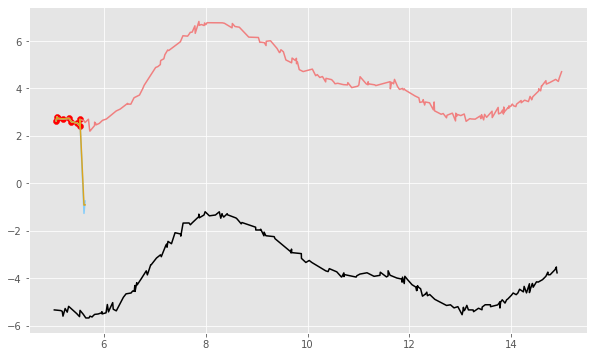

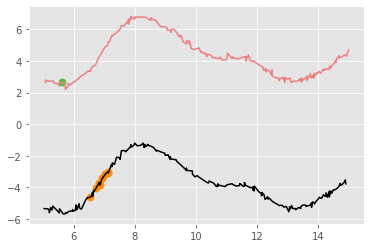

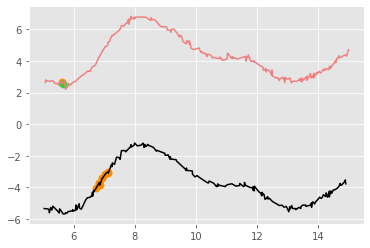

sample # 0, r squared: 0.9762002121676636


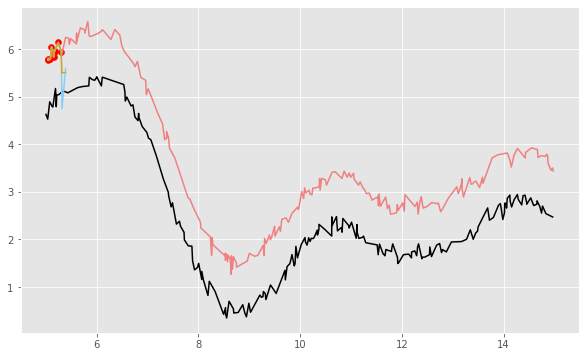

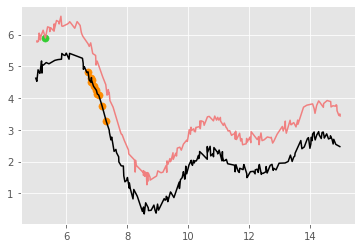

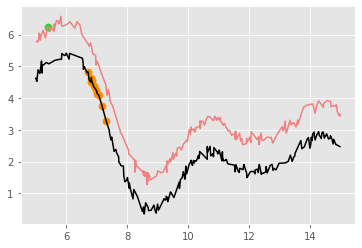

sample # 0, r squared: 0.9859931980914075


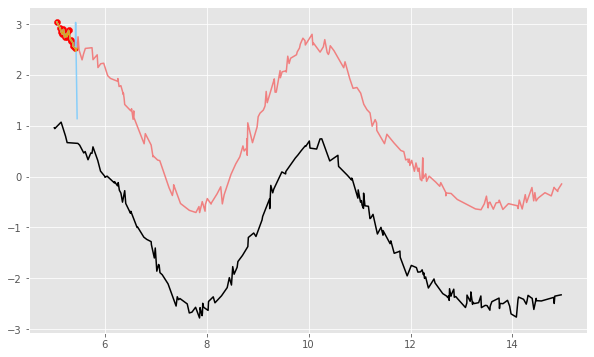

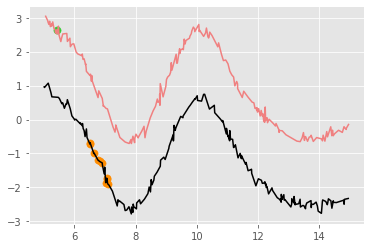

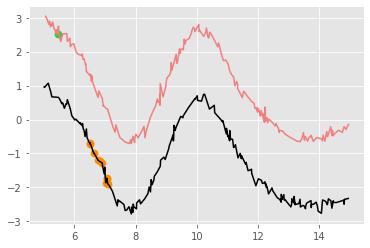

In [17]:
for i in range(100):
    idx = int(np.random.choice(np.arange(0, 30000, 1), 1))
    xx, yy, no_s_x1, no_s_y1, x_infer, em, s_y_inf,  n_s_x0_p, n_s_y0_p, n_s_x0, n_s_y0 = plotter.infer_plot2D(decoder, x = data[2][idx, :], y = data[6][idx, :], em = data[3][idx, :], em_2 = data[0][idx, :], samples = 1, num_steps = 2, consec = True, order = True, context_p = 10)

In [11]:
import glob
from PIL import Image

# filepaths
fp_in = image_folder = '/Users/omernivron/Downloads/attention_plots/*.png'
fp_out = "/Users/omernivron/Downloads/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=700, loop=0)

